# ***Voorspellen van Verhuuraantallen*** 

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Declan van den Hoek|declanvdh|DeclanvandenHoek|
|Isa Dijkstra|isadijkstra|IsaD01|

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om de verhuuraantallen te voorspellen. Er is niet bekend gemaakt wat het product is dat wordt verhuurd. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning/tree/main/Verhuuraantallen), om makkelijk de bestanden te delen. Van elk model zijn de voorspellingen ook geupload naar [Kaggle](https://www.kaggle.com/competitions/voorspel-verhuuraantallen-2023).

## **Inhoudsopgave** <a name='begin'></a>

1. [H1: Inladen libaries en data](#h1)
2. [H2: Explorative Data Analysis](#h2)
    1. [H2.1: Data opschonen](#h2.1)
    2. [H2.2: Grafieken zonder time series](#h2.2)
    3. [H2.3: Time Series Analyses](#h2.3)
        1. [H2.3.1: Seizoens Analyse met FFT](#h2.3.1)
        2. [H2.3.2: Trend Analyse](#h2.3.2)
        3. [H2.3.3: Autocorrelatie en Cycli](#h2.3.3)
    4. [H2.4: Grafieken met time series](#h2.4)
4. [H3: Modelleren](#h3)
    1. [H3.1: Linear Regression](#h3.1)
    2. [H3.2: KNN Regressor](#h3.2)
    3. [H3.3: Decision Tree Regressor](#h3.3)
    4. [H3.4: Random Forest Regressor](#h3.4)
    5. [H3.5: XGBoost Regressor](#h3.5)
    6. [H3.6: Ensemble, StackingRegressor](#h3.6)
    7. [H3.7: Hybride Modeleren](#h3.7)
    8. [H3.8: SARIMAX Model](#h3.8)
    9. [H3.9: KEUZE_MODEL_ISA](#h3.9)
5. [H4: Bevindingen](#h4)
6. [H5: Conclusie](#h5)
7. [Literatuurlijst](#bronnen)

## **H1: Inladen libaries en data** <a name='h1'></a>

In [235]:
# Standaard libaries voor visualiseren en dataverwerking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libaries gebruikt bij de seizoens analyse
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Libaries gebruikt bij trend analyse

# Libaries gebruikt bij autocorrelatie
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libaries gebruikt bij functies rondom modelleren
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller

# Libaries van de modellen
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.api import AutoReg
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

Aan de hand van de pandas libary is het nu mogelijk om de csv bestanden in te laden.

In [388]:
# Inladen van de test dataset
data_test = pd.read_csv('test.csv', sep = ',')

# Inladen van de train dataset
data_train = pd.read_csv('train.csv', sep = ',')

Nu de data is ingeladen zullen de eerste 5 regels worden getoond van de train dataset.

In [389]:
# Tonen van de eerste 5 regels
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H2: Explorative Data Analysis**<a name='h2'></a>

In dit hoofdstuk zal er worden gewerkt aan de Explorative Data Analysis. Deze stap zal ons helpen om beter inzichten krijgen met betrekking tot de data.

### **H2.1: Data Opschonen** <a name='h2.1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen. Vervolgens kan de .describe() method worden gebruikt om een inzicht te krijgen van hoe de numerieke waarden zijn verdeeld.

In [238]:
# Tonen van de kern informatie over kolommen
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


Uit deze diagram is gebleken dat de data_hour kolom niet een data_time object is.

In [239]:
data_train['date_hour'] = pd.to_datetime(data_train['date_hour'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 1.0 MB


Uit de .info() diagram is ook af te leiden dat elke cel hetzelfde aantal waardes bevat. Dit zou aan kunnen geven dat er geen waardes missen. De datatypes zijn ook allemaal integers of floats (behalve de datum), hieruit is af te leiden dat deze kolommen bestaan uit numerieke waardes. 

In [240]:
# Tonen van informatie over numerieke kolommen
data_train.describe()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,2011-12-18 02:20:08.294764544,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
min,2011-01-01 00:00:00,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2011-06-27 05:00:00,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,2011-12-18 06:00:00,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,2012-06-09 02:00:00,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,2012-11-30 23:00:00,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000
std,NaN,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755


Volgens de opdrachtbeschrijving zijn sommige kolommen al genormaliseerd, en zouden er geen maximale waardes boven de 1 moeten zijn. Als we naar de dataset kijken klopt dit, voor de kolommen "temp". "atemp" en "hum". Opvallend is dat de kolom "windspeed" ook genormaliseerd zou moeten zijn, maar de maximale waarde onder de 1.0 ligt. Dit kan aan geven dat de data niet goed is genormaliseerd.

In [241]:
min_value = data_train['windspeed'].min()
max_value = data_train['windspeed'].max()

data_train['windspeed'] = (data_train['windspeed'] - min_value) / (max_value - min_value)

data_train.describe()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,2011-12-18 02:20:08.294764544,0.028671,1.415580,0.504745,0.482608,0.624756,0.223709,190.477009
min,2011-01-01 00:00:00,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2011-06-27 05:00:00,0.000000,1.000000,0.340000,0.333300,0.470000,0.122840,41.000000
50%,2011-12-18 06:00:00,0.000000,1.000000,0.520000,0.500000,0.620000,0.228047,143.000000
75%,2012-06-09 02:00:00,0.000000,2.000000,0.660000,0.621200,0.780000,0.298225,282.000000
max,2012-11-30 23:00:00,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,977.000000
std,NaN,0.166885,0.637298,0.192369,0.171557,0.193227,0.143312,182.026755


In [242]:
def boxplot_outliers(dataframe, column_name):
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataframe[column_name], vert=False)
    plt.title(column_name)
    plt.show()

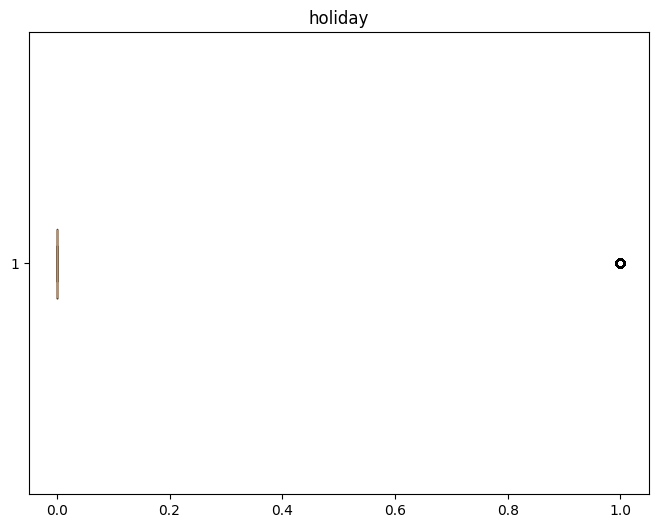

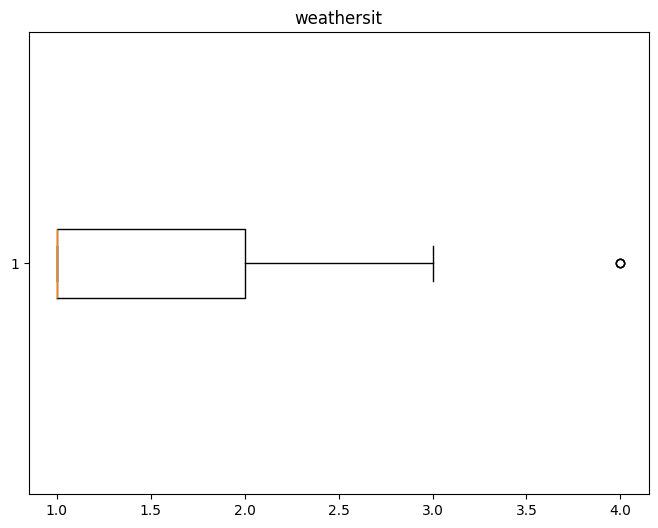

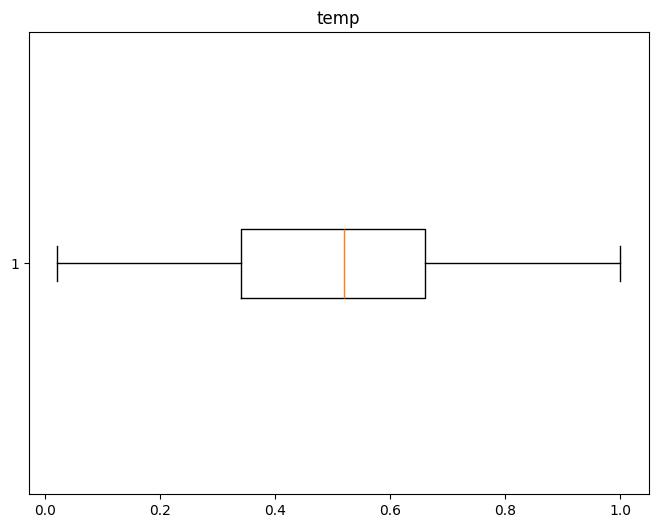

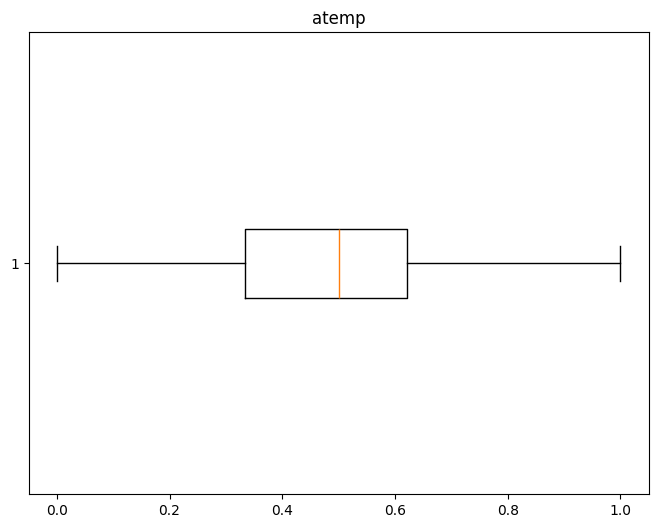

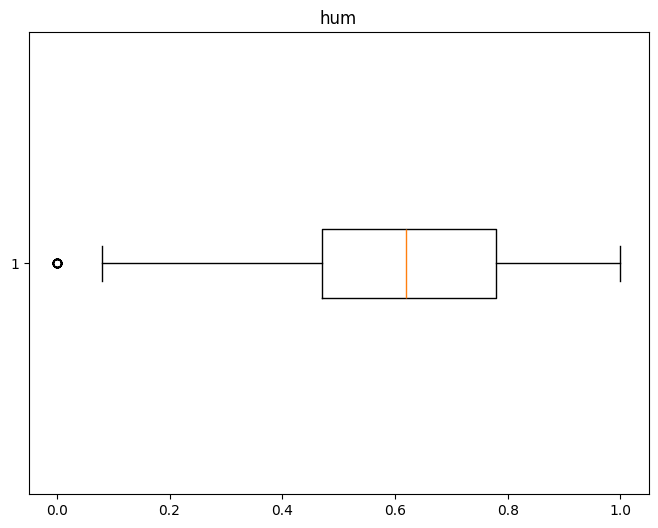

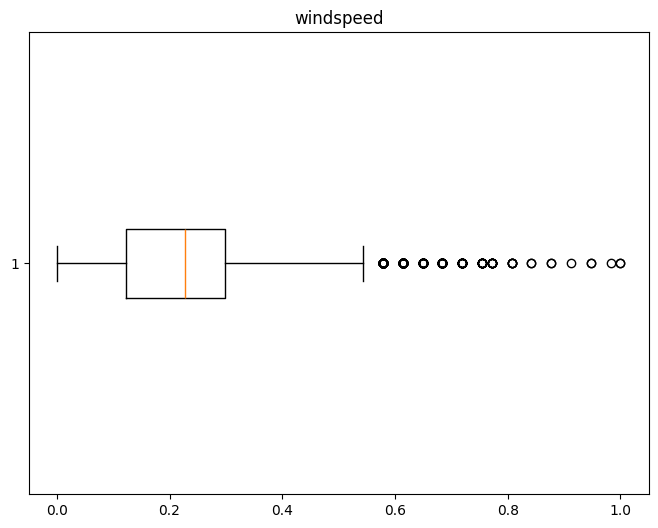

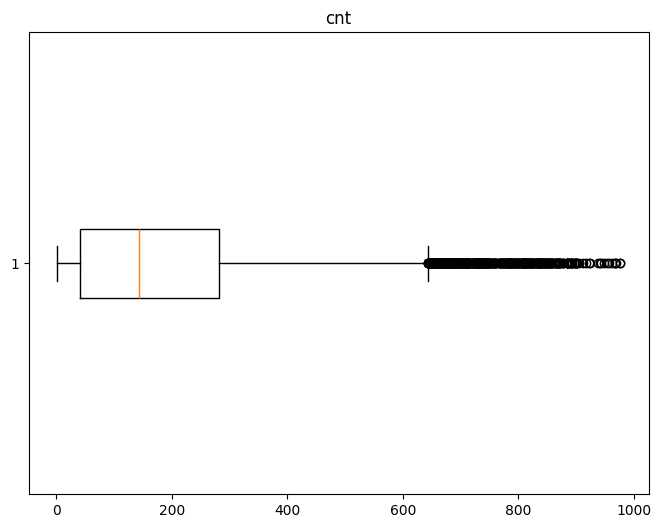

In [243]:
for col in data_train.columns:
    if col != 'date_hour':
        boxplot_outliers(data_train, col)

In de boxplot voor windspeed is te zien dat er een aantal outliers zijn. We gaan kijken naar deze rijen.

In [244]:
outliers_windspeed = data_train[data_train['windspeed'] > 0.58]

outliers_windspeed

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
178,2011-01-08 17:00:00,0,1,0.16,0.1212,0.37,0.649112,69
194,2011-01-09 09:00:00,0,1,0.12,0.0758,0.46,0.614083,19
196,2011-01-09 11:00:00,0,1,0.16,0.1212,0.40,0.614083,49
265,2011-01-12 12:00:00,0,1,0.20,0.1515,0.47,0.684260,55
271,2011-01-12 18:00:00,0,1,0.20,0.1515,0.47,0.614083,137
...,...,...,...,...,...,...,...,...
15876,2012-10-28 17:00:00,0,3,0.46,0.4545,0.77,0.614083,225
16207,2012-11-13 01:00:00,0,3,0.44,0.4394,0.88,0.754438,5
16468,2012-11-23 22:00:00,0,1,0.44,0.4394,0.33,0.614083,79
16472,2012-11-24 02:00:00,0,1,0.32,0.2727,0.39,0.719290,32



### **H2.2: Grafieken zonder Time Series** <a name='h2.2'></a>

In [245]:
class Grafieken:
    """
    Een class voor eenvoudig visualiseren met Matplotlib
    en seaborn.

    Parameters:
    ----------
    df : pandas.DataFrame
        Een pandas.DataFrame die data bevat om mee te
        visualiseren.
    """

    def __init__(self, df, target=False):
        """
        De constructor voor de Grafieken class

        Parameters:
        ----------
        df : pandas.DataFrame
            Een pandas.DataFrame die data bevat om mee te
            visualiseren.

        target : str (default = False)
            De kolomnaam van de target kolom, indien toepasbaar
        """
        # Aanmaken self.df
        self.df = df.drop('date_hour', axis=1)

        # Zetten van de target
        if target:
            self.target = target

        # Aanmaken grafiek standaarden
        self.figsize = (15,5)
        self.pallete = 'deep'


    def boxplots(self):
        """
        Maakt een aantal box plots gelijk aan het aantal kolommen
        in de Dataframe. De box zijn tegen één specifieke kolom
        opgezet, om de verdeling t.o.v. die kolom te tonen.

        Parameters:
        ----------------
        df : Pandas DataFrame
            Een pandas DataFrame met kolommen waarvan je
            de verdeling wilt onderzoeken.

        kolom : str
            De naam van de kolom waarbij de verdeling bekeken
            word, ten opzichte van de andere kolommen.

        Returns:
        ---------------
        None :
            In plaats van iets te returnen laat de
            functie meerdere boxplots zien.
        """
        # For-loop om elke kolom een eigen boxplot te geven
        for col in self.df.columns:
            # if-statement om te voorkomen dat de
            # kolom-parameter ook een boxplot krijgt
            if col != self.target:
                # Zetten van de grootte van de plot
                plt.subplots(figsize=self.figsize)

                # Maken en benoemen van de assen van de boxplots
                sns.boxplot(x=col, y=self.target,
                            data=self.df, color='pink')
                plt.xlabel(col)
                plt.ylabel(self.target)
                plt.title('{} vs. {}'.format(col, self.target))
                plt.show()
            
    def barplots(self):
        """
        Maakt een aantal bar plots gelijk aan het aantal kolommen
        in de Dataframe. De bar is tegen één specifieke kolom
        opgezet, om de verdeling t.o.v. die kolom te tonen.

        Parameters:
        ----------------
        df : Pandas DataFrame
            Een pandas DataFrame met kolommen waarvan
            je de verdeling wilt onderzoeken.

        kolom : str
            De naam van de kolom waarbij de verdeling
            bekeken word, ten opzichte van de andere kolommen.

        Returns:
        ---------------
        None :
            In plaats van iets te returnen laat
            de functie meerdere barplots zien.
        """
        # For-loop om elke kolom een eigen barplot te geven
        for col in self.df.columns:
            # if-statement om te voorkomen dat de
            # kolom-parameter ook een barplot krijgt
            if col != self.target:
                # Zetten van de grootte van de plot
                plt.subplots(figsize=self.figsize)

                # Maken en benoemen van de assen van de barplot
                sns.barplot(x=col, y=self.target,
                            data=self.df, color= 'skyblue')
                plt.xlabel(col)
                plt.ylabel(self.target)
                plt.title('{} vs. {}'.format(col, self.target))
                plt.show()
                
    def lineplots(self):
        """
        Maakt een aantal line plots gelijk aan het aantal kolommen
        in de Dataframe. De line is tegen één specifieke kolom
        opgezet, om de verdeling t.o.v. die kolom te tonen.

        Parameters:
        ----------------
        df : Pandas DataFrame
            Een pandas DataFrame met kolommen waarvan
            je de verdeling wilt onderzoeken.

        kolom : str
            De naam van de kolom waarbij de verdeling
            bekeken word, ten opzichte van de andere kolommen.

        Returns:
        ---------------
        None :
            In plaats van iets te returnen laat
            de functie meerdere lineplots zien.
        """
        # For-loop om elke kolom een eigen barplot te geven
        for col in self.df.columns:
            # if-statement om te voorkomen dat de
            # kolom-parameter ook een barplot krijgt
            if col != self.target:
                # Zetten van de grootte van de plot
                plt.subplots(figsize=self.figsize)

                # Maken en benoemen van de assen van de barplot
                sns.lineplot(x=col, y=self.target,
                            data=self.df, color= 'green')
                plt.xlabel(col)
                plt.ylabel(self.target)
                plt.title('{} vs. {}'.format(col, self.target))
                plt.show()

    def heatmap(self):
        """
        Deze functie maakt een heatmap op basis
        van de DataFrame waarmee de class is gemaakt
        """
        # Aanmaken Heatmap
        fig, ax = plt.subplots(figsize=(5,15))
        ax = sns.heatmap(self.df.corr()[[self.target]].sort_values(
            by=[self.target], ascending=False
            ),square=False, annot=True, cmap='RdYlGn')
        plt.show()

    def timeplot(self, x_kolom, hue=None):
        """
        Maakt een bar en een boxplot op basis van een gegeven tijd.

        Parameters:
        ----------
        x_kolom : str
            De naam van de tijd gebaseerde kolom

        hue : str
            De naam van de kolom waarop de bars en boxes
            worden ingedeeld

        Returns:
        ----------
        None :
            In plaats van iets te returnen laat
            de functie een bar- en een boxplot zien.
        """
        # Aanmaken van plotgrootte en barplot
        plt.subplots(figsize=self.figsize)
        sns.barplot(data=self.df, x=x_kolom, y=self.target,
                    hue=hue, errorbar=None,
                    palette=self.pallete)

        # Aanmaken van de assen
        plt.title(f'Verhuuraantallen per {x_kolom}')
        plt.ylabel('Verhuuraantallen')
        plt.show()

        # Aanmaken van plotgrootte en boxplot
        plt.subplots(figsize=self.figsize)
        sns.boxplot(data=self.df, x=x_kolom, y=self.target,
                    hue=hue, palette=self.pallete)

        # Aanmaken van de assen
        plt.title(f'Verdeling van Verhuuraantallen per {x_kolom}')
        plt.ylabel('Verhuuraantallen')
        plt.show()

In [246]:
graf = Grafieken(data_train, 'cnt')

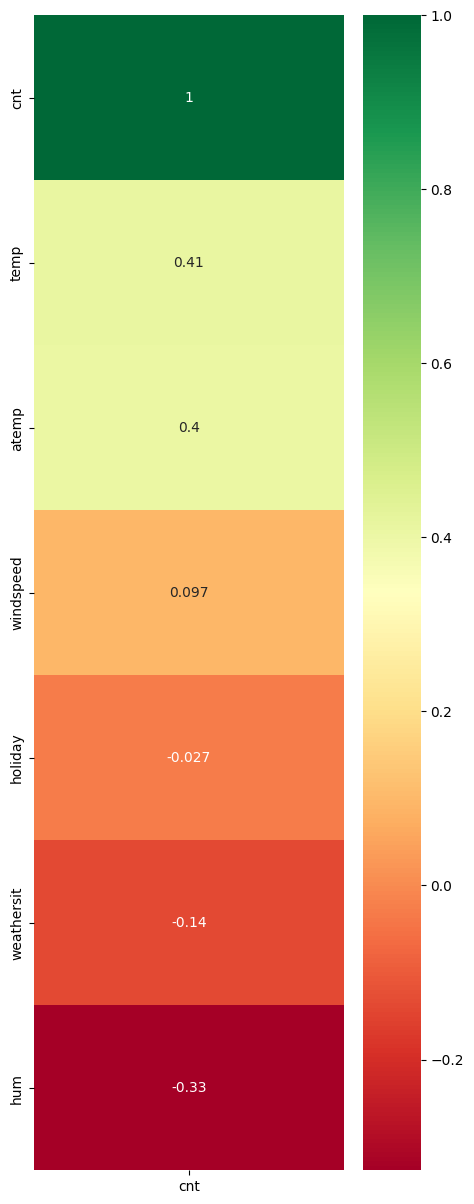

In [247]:
graf.heatmap()

Aan de hand van deze heatmap kun je zien dat de hum, temp en atemp de meeste invloed hebben op de hoeveelheid die wordt verhuurd.
Door de frequentie van de data (elk uur) is er een te grote schommeling tussen de mogelijke waarden. Om beter te kunnen kijken naar eventuele patronen is het dus nodig om in te gaan zoomen op bepaalde perioden. Om te beginnen met inzoomen kijken we naar de maand april.

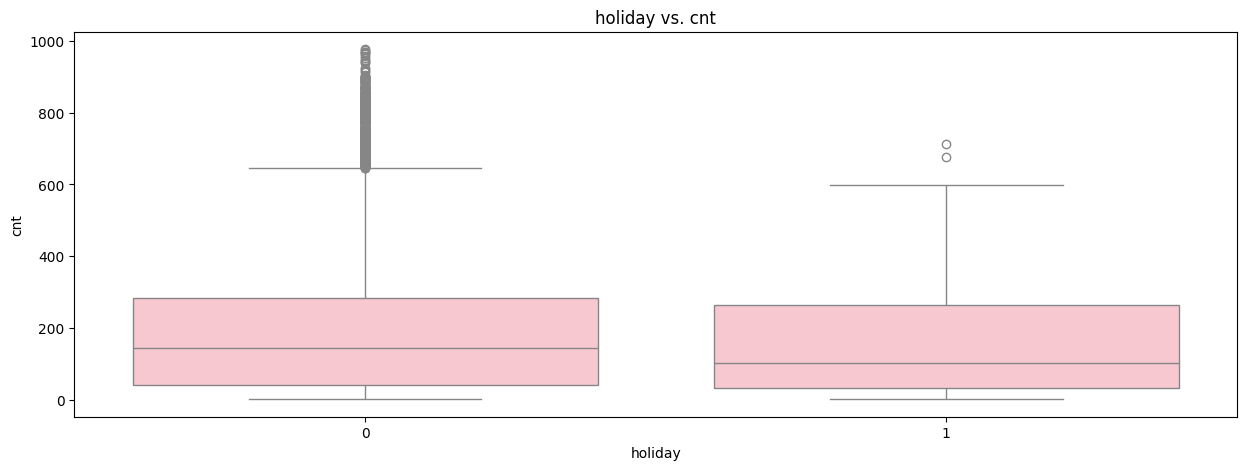

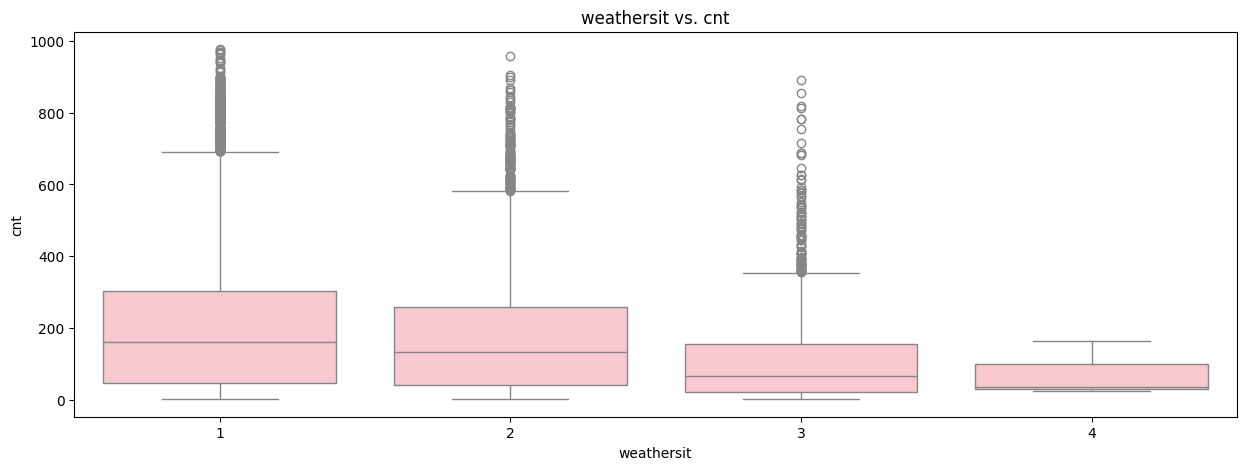

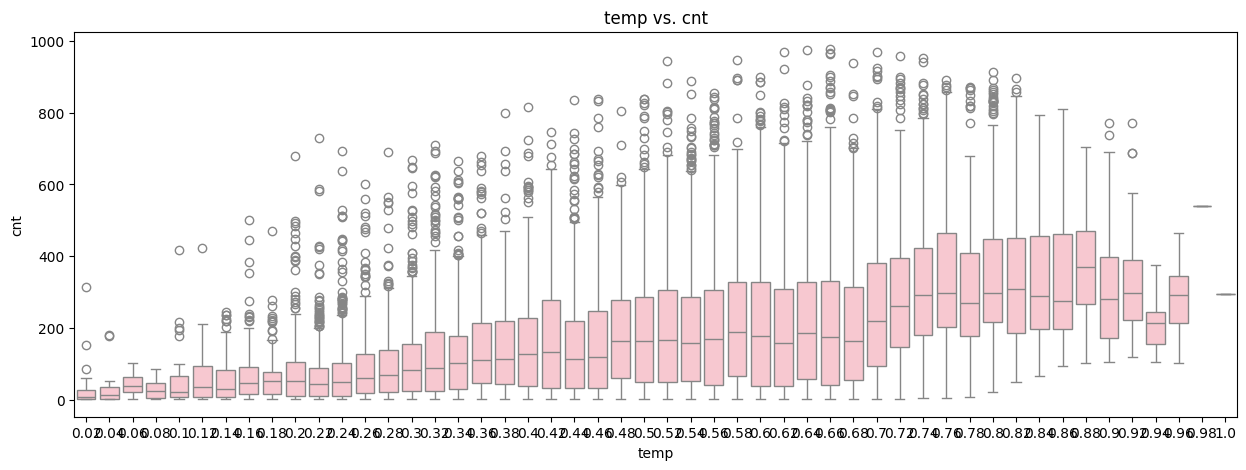

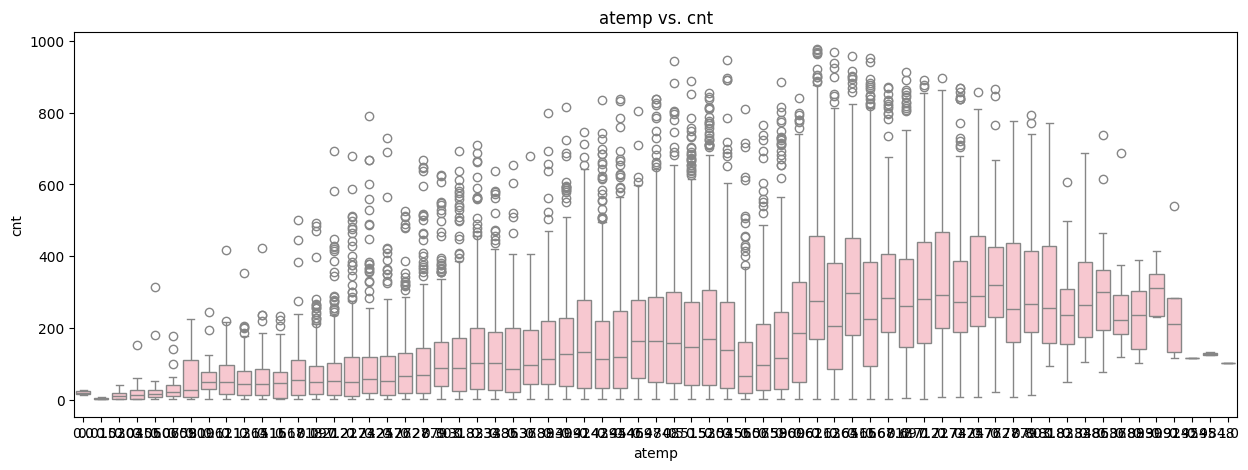

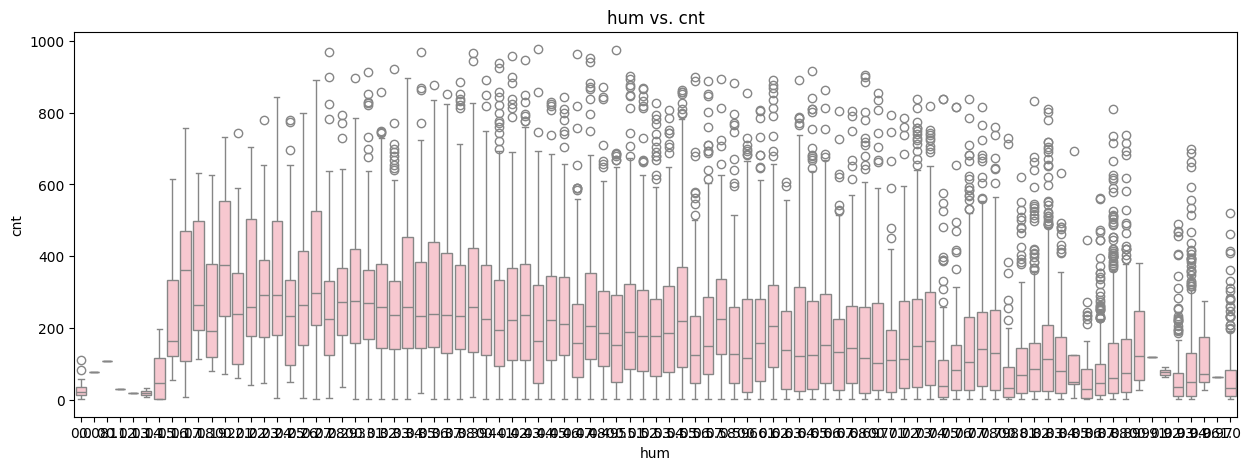

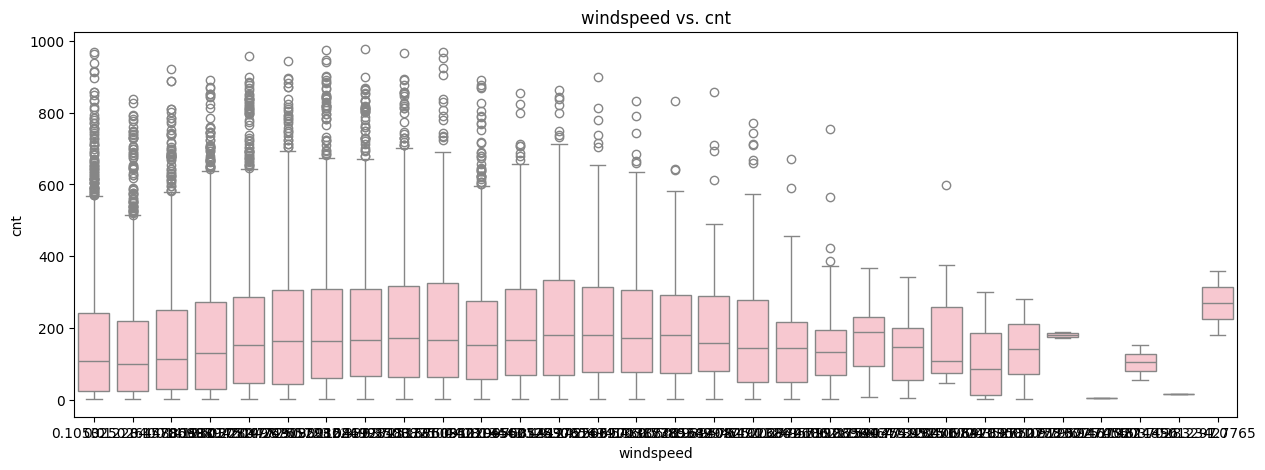

In [248]:
graf.boxplots()

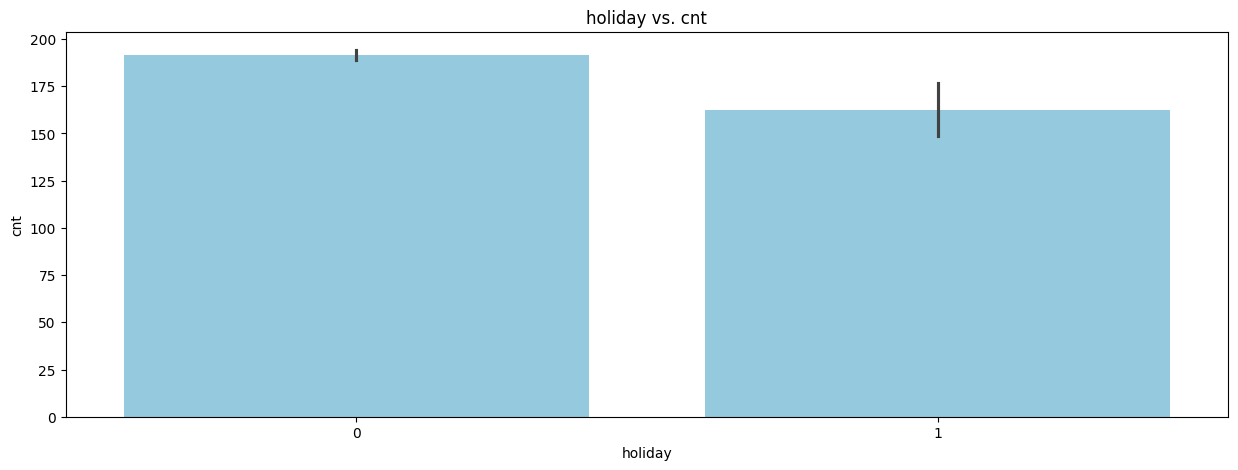

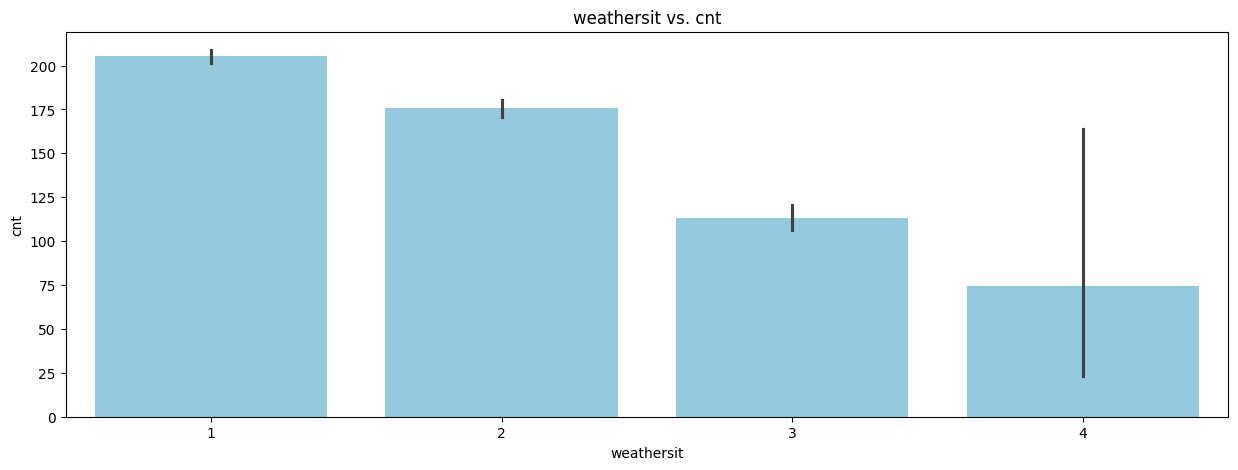

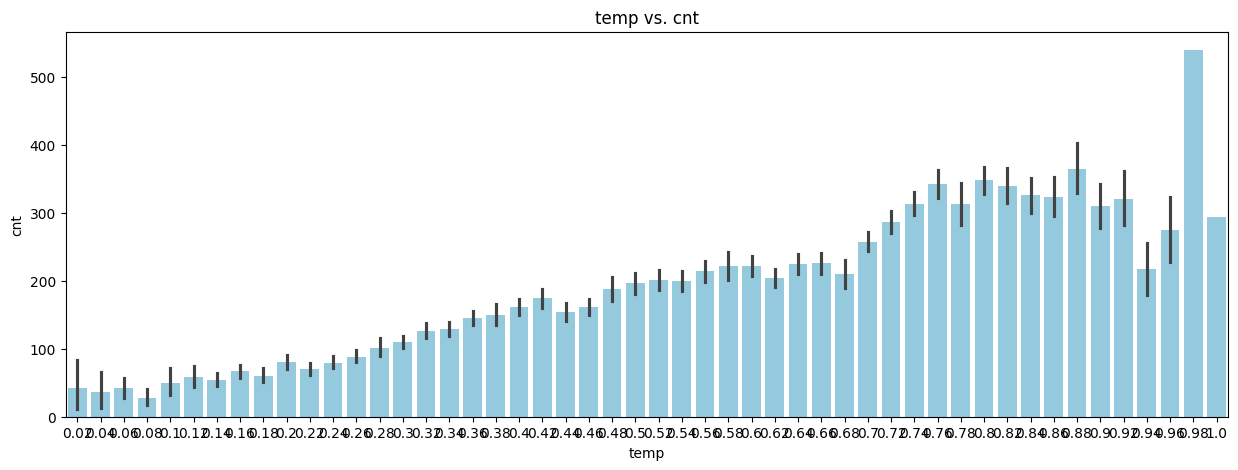

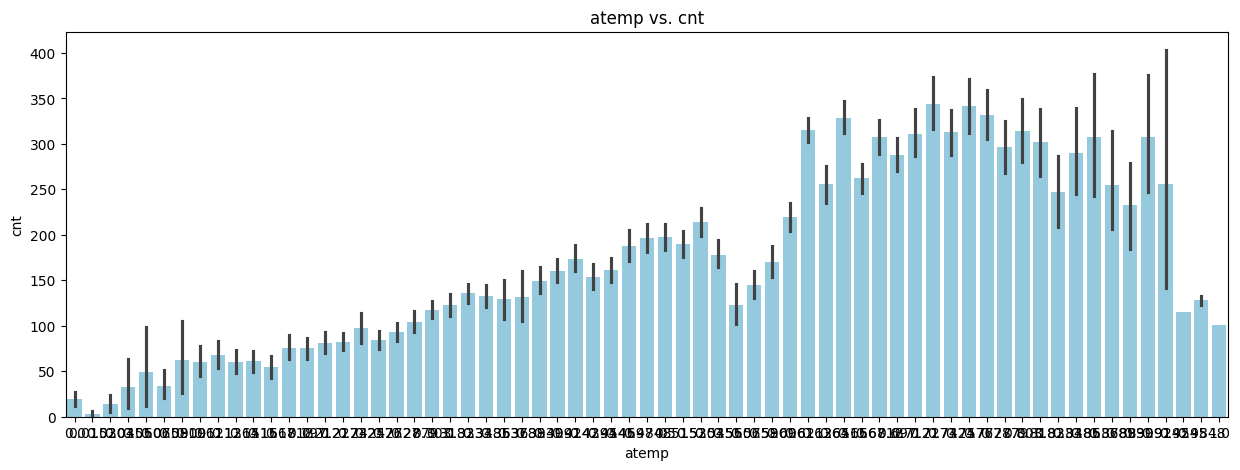

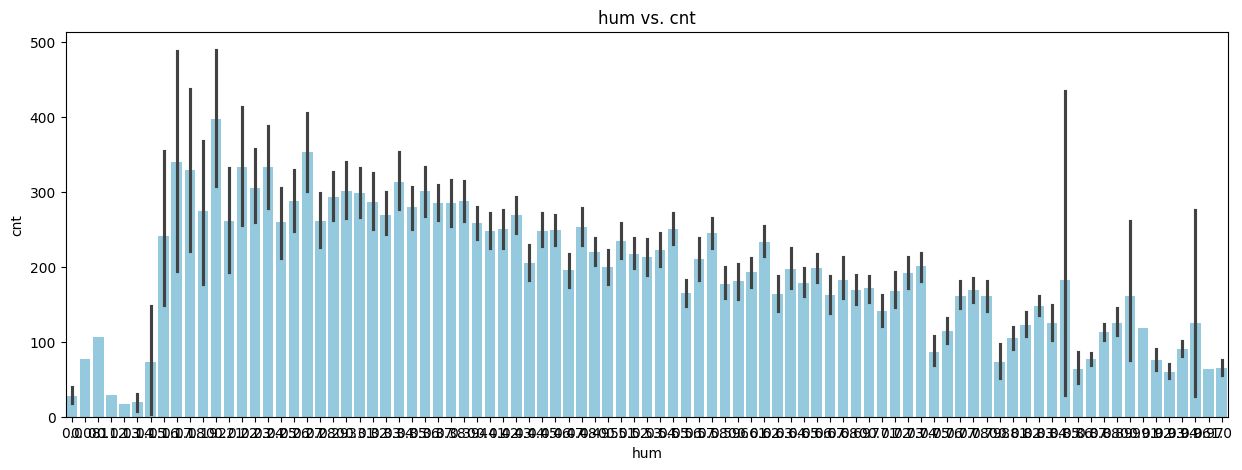

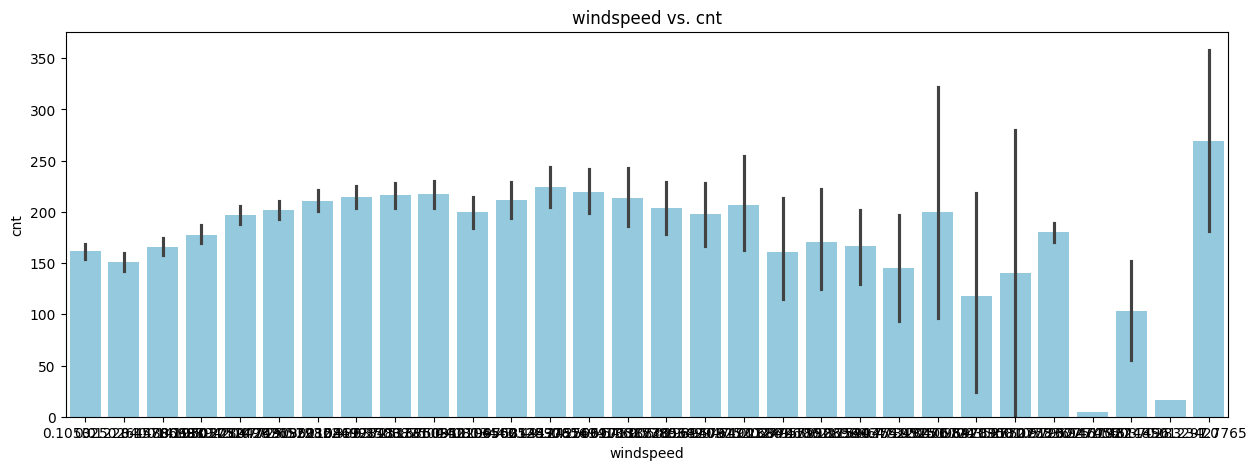

In [249]:
graf.barplots()

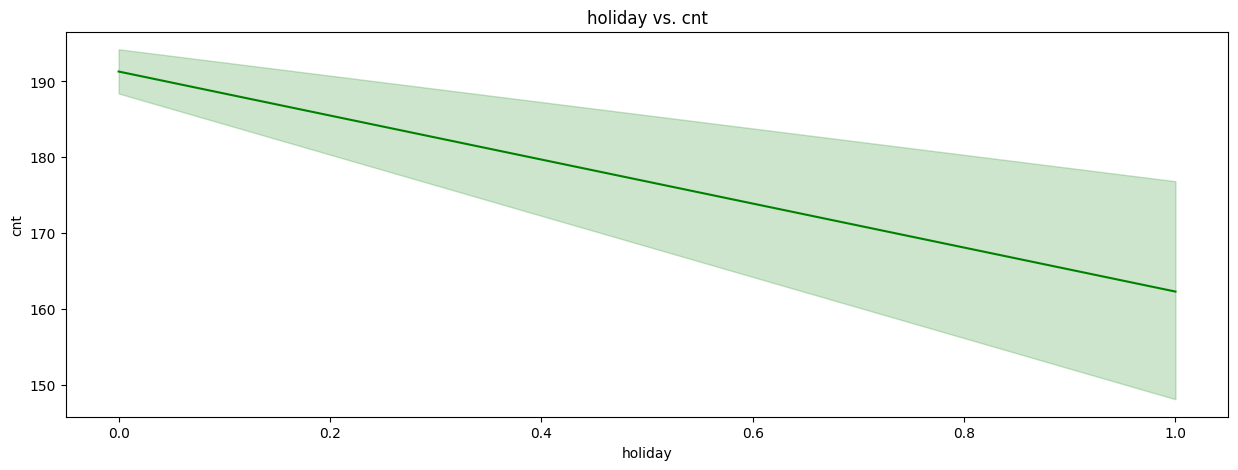

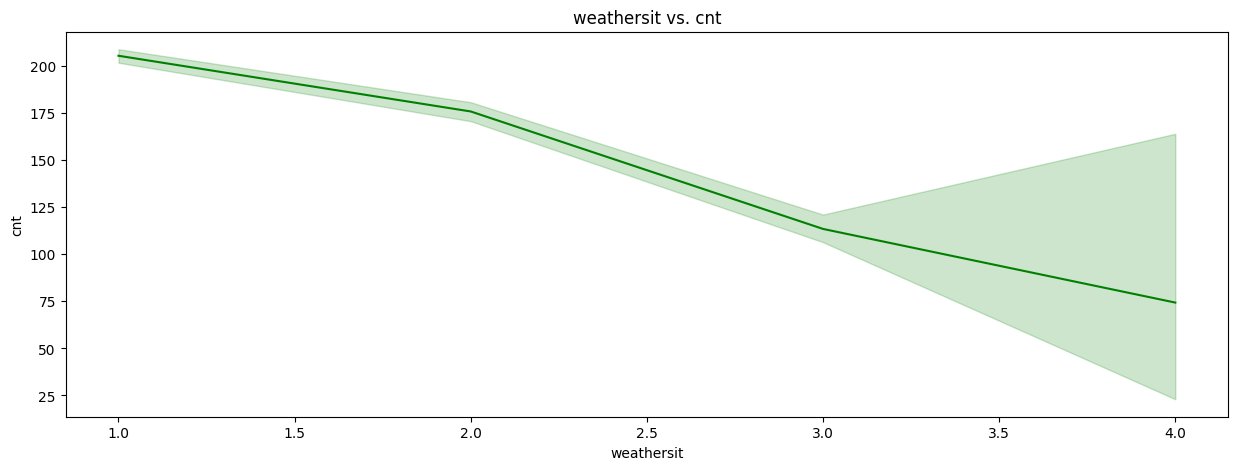

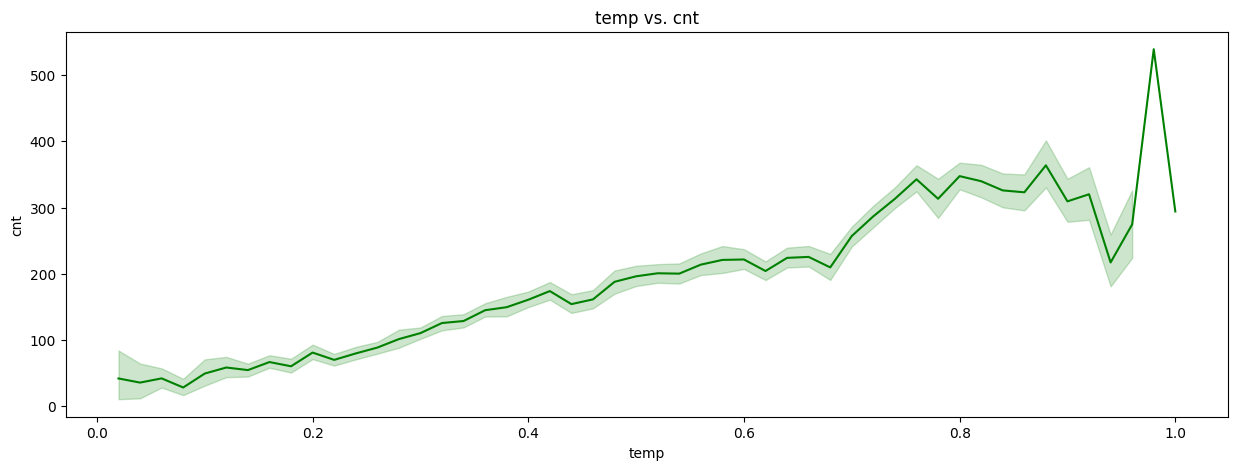

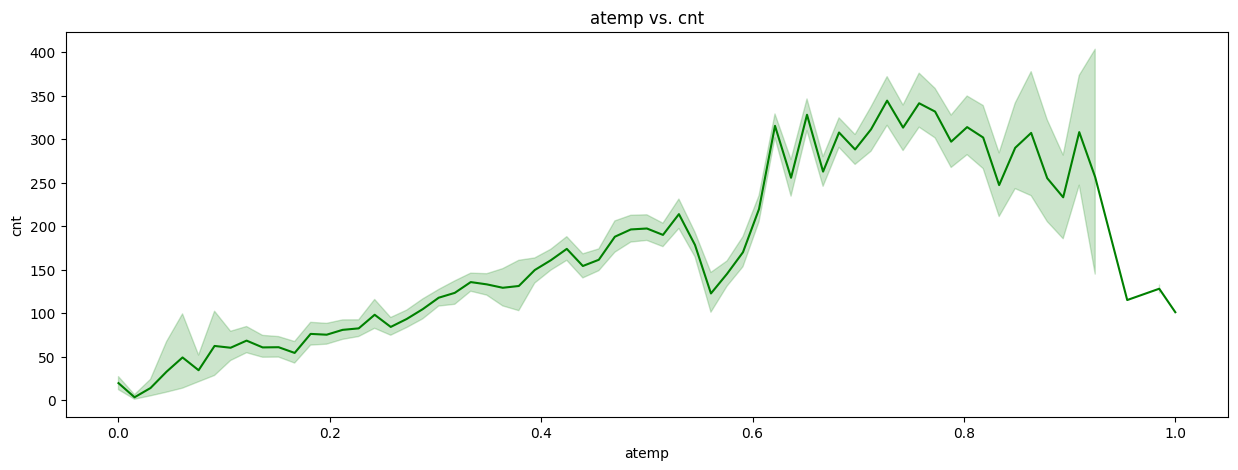

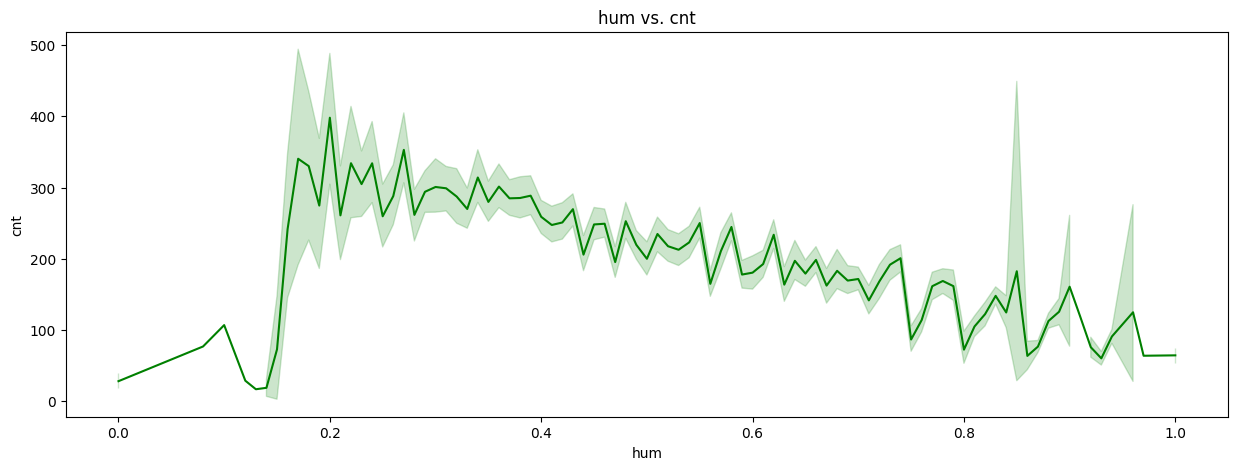

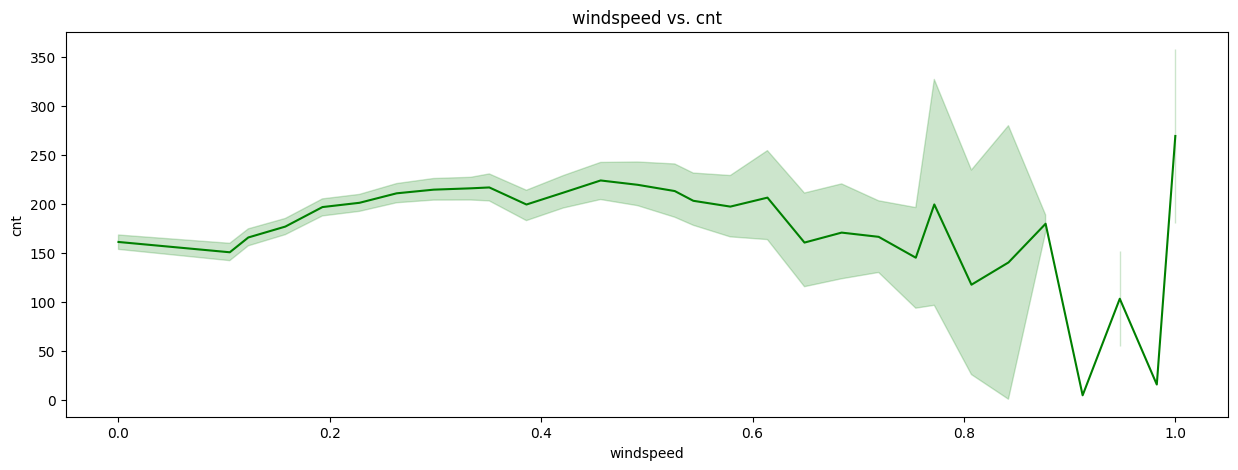

In [250]:
graf.lineplots()

In de visualisaties kun je zien dat holiday (0) zorgt voor meer verhuuraantallen van het product. Ook zie je dat hoe hoger de weathersite, hoe meer er van het product wordt verhuurd. Ook zie je een stijgende lijn in de temperatuur en de verhuurde aantallen. Windspeed loopt geleidelijk met een paar uitschieters. Hum loopt juist af, dus een lagere hum zorgt voor meer verhuur, maar de hum moet ook weer niet te laag zijn want dan verhuur je bijna niks. 

### **H2.3: Time Series analyses** <a name='h2.3'></a>

Omdat er met Time-Series data wordt gewerkt, is het nodig om deze verder te gaan onderzoeken. Hiervoor is eerst een nieuw dataframe nodig, waarin alleen de tijd en de verhuuraantallen staan.

In [251]:
# Aanmaken van nieuw DataFrame
df_time = data_train[['date_hour', 'cnt']].copy()
df_time['date_hour'] = pd.to_datetime(df_time['date_hour'])
df_time = df_time.set_index('date_hour')
df_time.head()

,cnt
date_hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


#### **H2.3.1: Seizoens Analyse (met FFT)** <a name='h2.3.1'></a>

Nu het dataframe df_time is aangemaakt kan deze gebruikt worden voor verschillende time-series analyse technieken. Deze technieken worden gebruikt om patronen uit de tijds data te kunnen halen. Om hiermee te beginnen wordt het dataframe in een grafiek gezet. Hierbij zal 2012 gehighlight worden om snel te kunnen zien waar in de grafiek de strat van het nieuwe jaar zich bevindt.

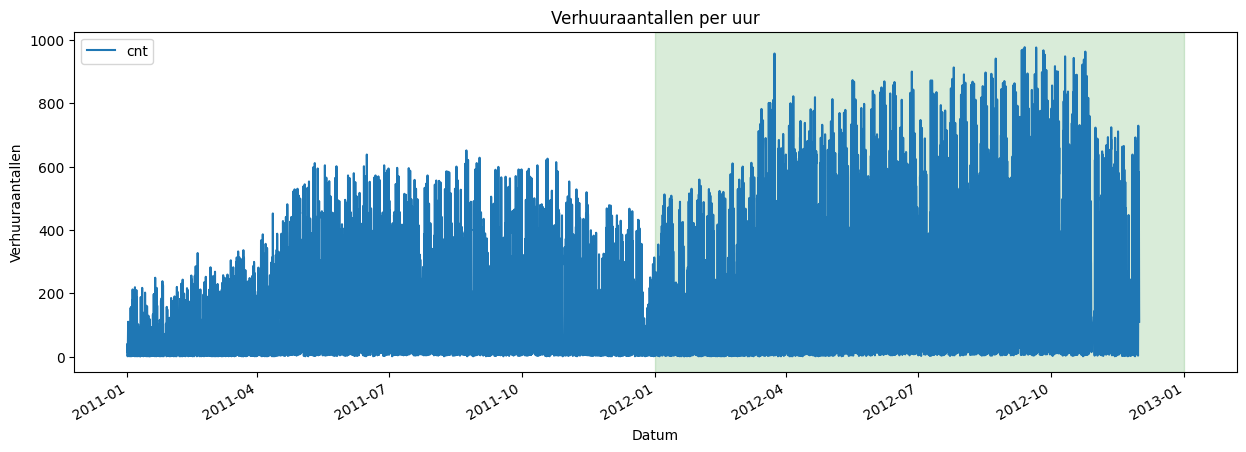

In [252]:
# Aanmaken van standaard plot
ax = df_time.plot(figsize=(15, 5))

# Toevoegen van shading om beter te zien waar 2012 begint
ax.axvspan('2012-01-01', '2013-01-01', color='green', alpha=0.15)

# Aanpassen van de plot labels en titel
ax.set_xlabel("Datum")
ax.set_ylabel("Verhuuraantallen")
ax.set_title("Verhuuraantallen per uur")

# Tonen van de plot
plt.show()

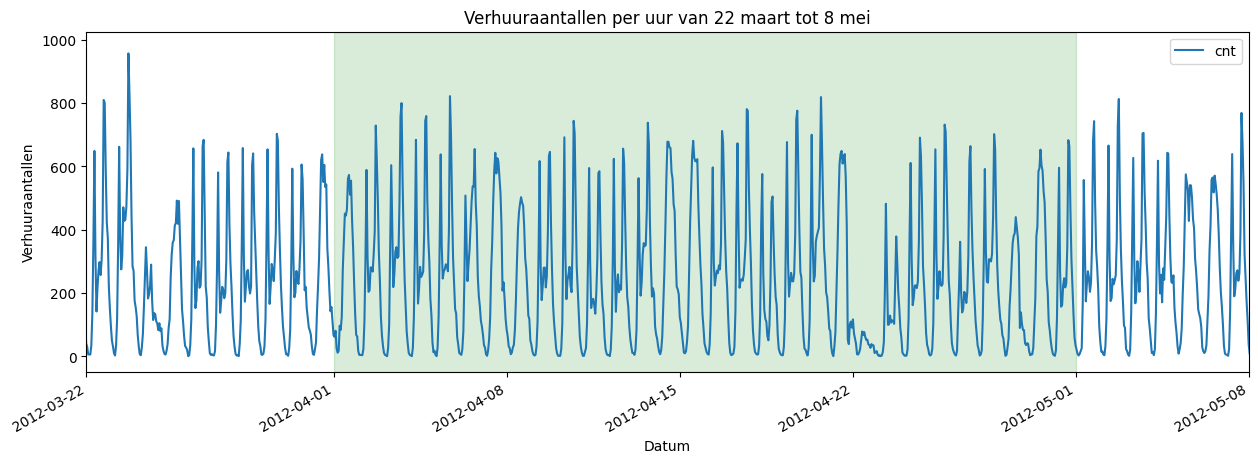

In [253]:
# Aanmaken van standaard plot
ax = df_time.plot(figsize=(15, 5))

# Toevoegen van shading om beter te zien welke data April is
ax.axvspan('2012-04-01', '2012-05-01', color='green', alpha=0.15)

# Aanpassen van de plot labels en titel
ax.set_xlim('2012-03-22', '2012-05-08')
ax.set_xlabel("Datum")
ax.set_ylabel("Verhuuraantallen")
ax.set_title("Verhuuraantallen per uur van 22 maart tot 8 mei")

# Tonen van de plot
plt.show()

Wat hier te zien valt is dat er een patroon vormt in de pieken. Dit patroon herhaalt zich relatief consistent. Hoewel deze rond 22 april zich niet herhaald, is het belangrijk om niet van de uitzondering de regel te gaan maken. Omdat deze herhaling per maand meerdere malen voorkomt is het van belang om te kijken naar de data per week. Op deze manier kan vastgesteld worden of er per week ook een herlaing plaats vind. Om dit gemakkelijk te berekenen en te visualiseren wordt er gebruik gemaakt van de seasonal_decompose functie van de statsmodels libary.

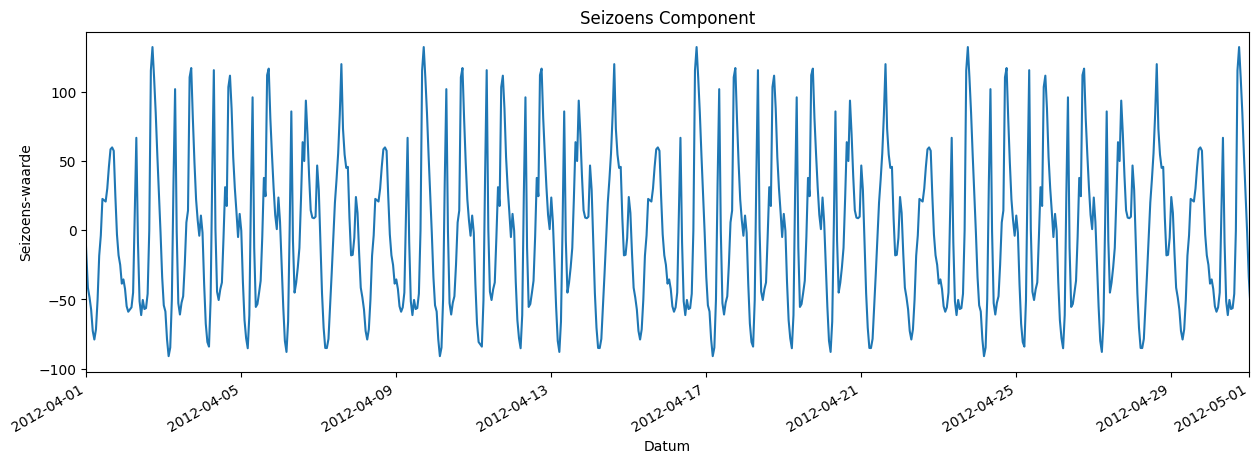

In [254]:
# Gebruiken van seasonal_decompose om seizoens patronen te visualiseren
result = seasonal_decompose(df_time['cnt'], model='additive', period=24*7)

# Maken van de plot
plt.figure(figsize=(15, 5))
result.seasonal.plot()
plt.title('Seizoens Component')
plt.xlim('2012-04-01', '2012-05-01')
plt.xlabel('Datum')
plt.ylabel('Seizoens-waarde')
plt.show()

Wat hier te zien valt is dat er een duidelijke seizoensmatige beweging in de data zit. Momenteel is er een patroon dat zich 4 maal volledig toont. Vanuit deze wetenschap is er dan vanuit te gaan dat deze seizoenspatronen ongeveer een week duren. Om dit beter te kunnen bekijken zoomen we nu in op een periode van 10 dagen. Hierin zou het patroon zich moeten uiten en zal er een nieuwe herhaling aan het einde moeten beginnen.

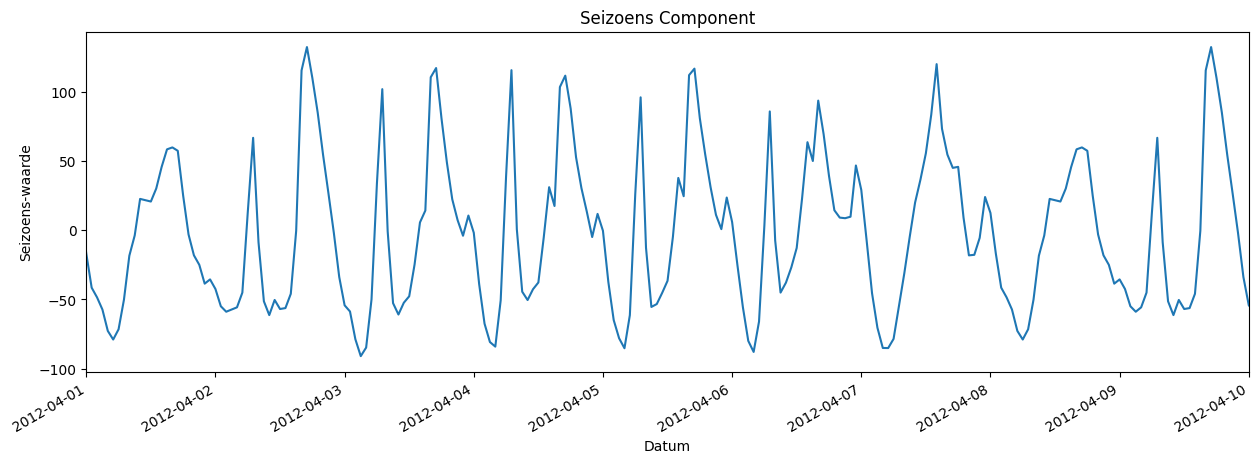

In [255]:
# Gebruiken van seasonal_decompose om seizoens patronen te visualiseren
result = seasonal_decompose(df_time['cnt'], model='additive', period=24*7)

# Maken van de plot
plt.figure(figsize=(15, 5))
result.seasonal.plot()
plt.title('Seizoens Component')
plt.xlim('2012-04-01', '2012-04-10')
plt.xlabel('Datum')
plt.ylabel('Seizoens-waarde')
plt.show()

Dagelijks herhaalt zich een soortgelijk patroon. Er zijn kleine verschillen in aan te wijzen, maar de meeste dagen bevatten 2 pieken. Deze pieken vormen zich langzamerhand samen, waarna het weer scheidt naar twee pieken. De periode die het duurt om same te voegen is 5 dagen, terwijl de periode om te splitsen 2 dagen duurt. Het is aannemelijk dat het hierbij dus om de werkdagen en het weekend zal gaan.

Peaks found at [692 694]


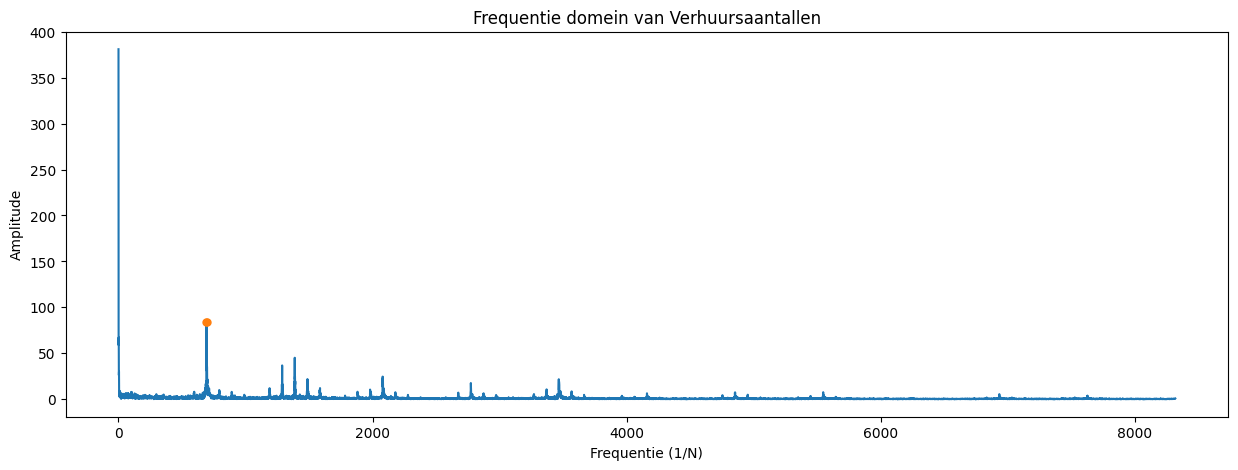

In [256]:
# Berekenen aantal datapunten
N = len(df_time)

# Uitvoeren Fourier Transform
ft = np.fft.fft(df_time['cnt'])

# Bereken de kracht van de frequenties
magnitude = 2.0/N * np.abs(ft[:N//2])

# Zoeken en tonen van de pieken
peaks, _ = find_peaks(magnitude, height=75)
print(f"Peaks found at {peaks}")

# Plotten
plt.figure(figsize=(15,5))
plt.plot(magnitude)
plt.xlabel('Frequentie (1/N)')
plt.ylabel('Amplitude')
plt.title('Frequentie domein van Verhuursaantallen')
plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.show()

Nu de locatie van de hoogste piek is gevonden, kunnen de frequentie en de periode worden berekend. Doordat peaks een lijst is met 2 waarden, kan er voor beide waarden de periode worden berekend.

In [257]:
freq = peaks * (1 / N)
periode = 1 / freq
print(f'De periode van FFT is: {np.round(periode, 0)}')

De periode van FFT is: [24. 24.]


Een periode geeft aan dat de Fourier Transform een periodieke herhaling ziet om de 24 tijdsperioden. In onze dataset betekent dit dat er elke dag een patroon plaats vind. Hoewel we al weten dat dit patroon kan verschillen op basis van weekend of geen weekend, was er ook te zien dat van maandag tot en met vrijdag de bewegingen van de grafiek gelijk aan elkaar waren. Om deze reden zullen de kolommen 'day_of_week' en 'is_weekend' worden togevoegd, zodat de patronen gebruikt kunnen worden voor Machine Learning.

Nu zal er worden gekeken naar de fourier features die toegevoegd kunnen worden.

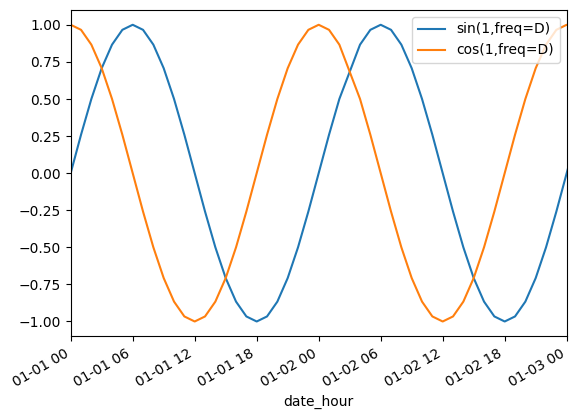

In [258]:
# Aanmaken fourier voor W en D
fourier_w = CalendarFourier(freq="W", order=1)
fourier_d = CalendarFourier(freq="D", order=1)

dp = DeterministicProcess(
    index=df_time.index,
    constant=False,
    order=1,
    seasonal=False,
    additional_terms=[fourier_w, fourier_d],
    drop=True,
)

fourier_feat = dp.in_sample()

ax = fourier_feat.plot(y='sin(1,freq=D)',
                       xlim=['2012-01-01', '2012-01-03'])
ax = fourier_feat.plot(ax=ax, y='cos(1,freq=D)',
                       xlim=['2012-01-01', '2012-01-03'])
plt.show()

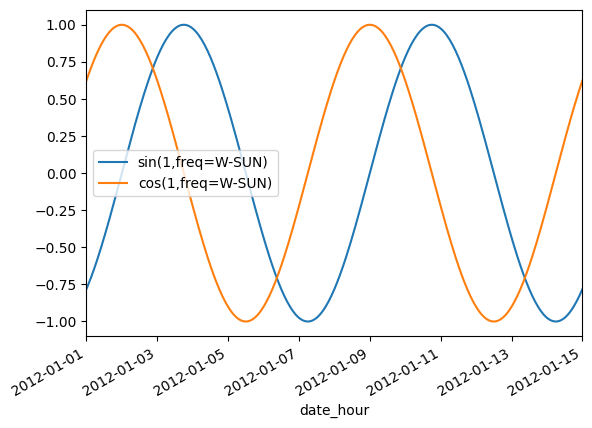

In [259]:
ax = fourier_feat.plot(y='sin(1,freq=W-SUN)',
                       xlim=('2012-01-01', '2012-01-15'))
ax = fourier_feat.plot(ax=ax, y='cos(1,freq=W-SUN)',
                       xlim=('2012-01-01', '2012-01-15'))
plt.show()

#### **H2.3.2: Trend Analyse** <a name='h2.3.2'></a>

Timeseries data is data verzameld over een periode van tijd. Deze data bestaat uit meerdere componenten, namelijk: de trendcomponent, seizoenscomponent, cyclische component en een willekeurig component. De trend component gaat over het gedrag van de data op de lange termijn, en negeert schommelingen op de korte termijn. Door het analyseren van de trendcomponent kunnen we data beter begrijpen, wat belangrijk is voor het voorspellen van toekomstige data. (Learn20stat, 2023)

Eerst onderzoeken we in hoeverre de trend component aanwezig is in onze data. Hier voor zijn er meerdere methoden die we kunnnen gebruiken. Een veel gebruikte methode is om moving averages te gebruiken. 

In [260]:
df_trend = data_train.set_index('date_hour')
df_trend

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.000000,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.000000,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.000000,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.000000,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.000000,1
...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.000000,377
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.000000,245
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.105325,183


Autocorrelatie is de correlatie/relatie van een tijdsreeks met een eerdere versie in tijd. Het helpt om herhalende patronen te vinden. https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
https://www.wikiwand.com/nl/Autocorrelatie

Cycli verwijzen naar herhalende patronen of fluctuaties in de tijdreeksgegevens.

Text(0.5, 1.0, 'Timeseries en Moving Average')

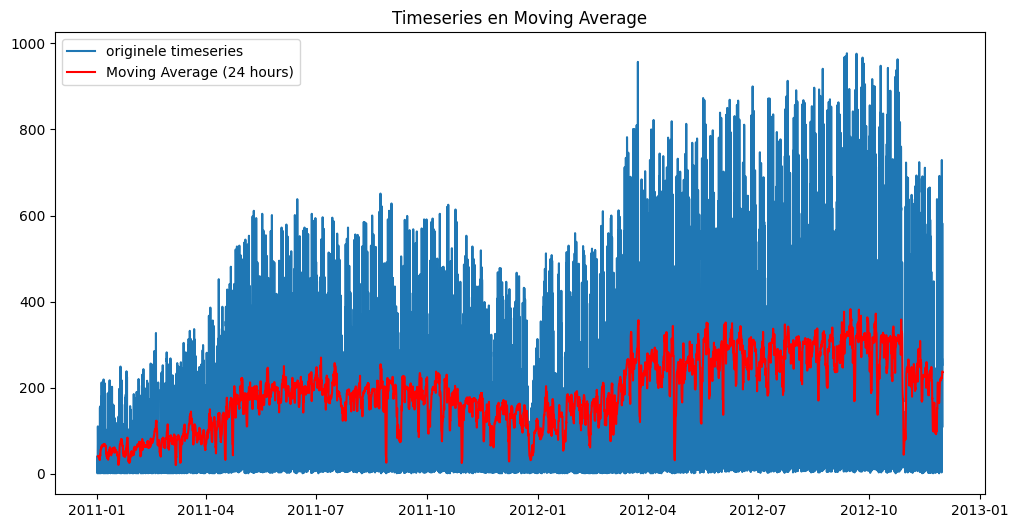

In [261]:
# Van date_hour de index maken
df_trend.index = pd.to_datetime(df_trend.index, format='%Y-%m-%d %H:%M:%S')  
df_trend = df_trend.asfreq('H')  

# Er voor zorgen dat er geen missende waardes zijn
df_trend['cnt'] = df_trend['cnt'].interpolate(method='linear', limit_direction='both')

# moving averages toepassen en toevoegen aan het dataframe
window_size = 24
df_trend['moving_avg'] = df_trend['cnt'].rolling(window=window_size).mean()


# De timeseries en trendcomponent tonen
plt.figure(figsize=(12, 6))
plt.plot(df_trend['cnt'], label='originele timeseries')
plt.plot(df_trend['moving_avg'], label=f'Moving Average ({window_size} hours)', color='red')
plt.legend()
plt.title('Timeseries en Moving Average')

In de grafiek is te zien dat er per jaar een boog gaat. De verhuuraantallen zijn in de zomer hoger. Goed te zien is dat de lijn in het tweede jaar in veel plekken hoger is dan in het vorige jaar. Dit kan een sterke opwaartse trend aangeven. Omdat de data over twee jaar gaat is het niet met zekerheid te zeggen of deze trend volhoud.
bronnen voor dit hoofdstuk

Learn20stat. (2023, March 30). Components of time series. Learn Statistics. https://www.learn-stat.com/what-are-components-of-time-series/

#### **H2.3.3: Autocorrelatie en Cycli** <a name='h2.3.3'></a>

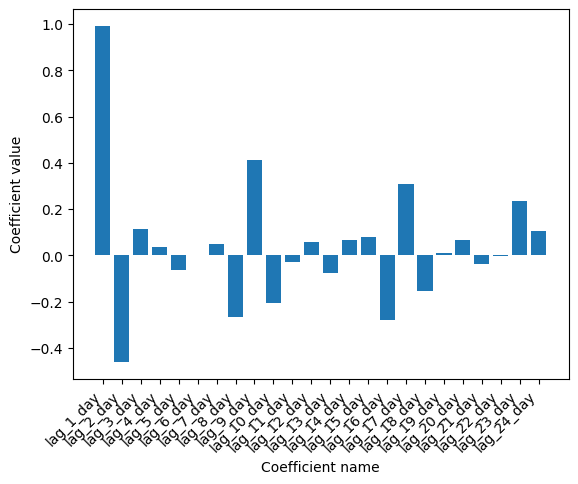

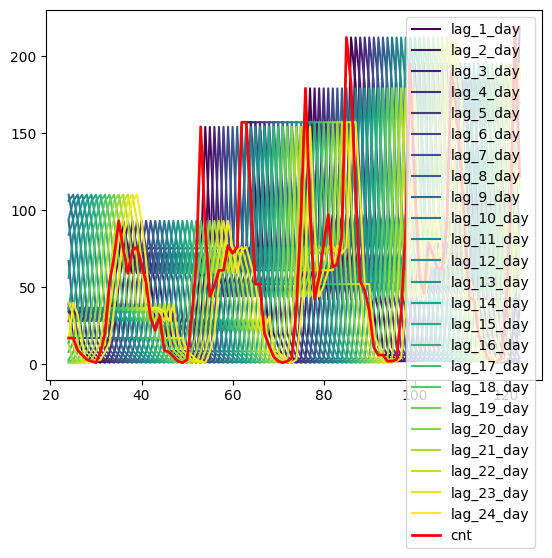

In [262]:
# These are the "time lags"
shifts = np.arange(1, 25).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): data_train['cnt'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
data_train_shifted_data = pd.DataFrame(shifted_data)

# Drop rows with NaN values introduced by the shift operation
data_train_shifted_data.dropna(inplace=True)

# Assuming 'target_variable' is the column you want to predict
target_variable = data_train['cnt'].iloc[data_train_shifted_data.index]

model = LinearRegression() 
model.fit(data_train_shifted_data, target_variable)

fig, ax = plt.subplots()
ax.bar(data_train_shifted_data.columns, model.coef_)
ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
# Set formatting so it looks nice
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Plot the first 100 samples of each
ax = data_train_shifted_data.iloc[:100].plot(cmap=plt.cm.viridis)
target_variable.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()


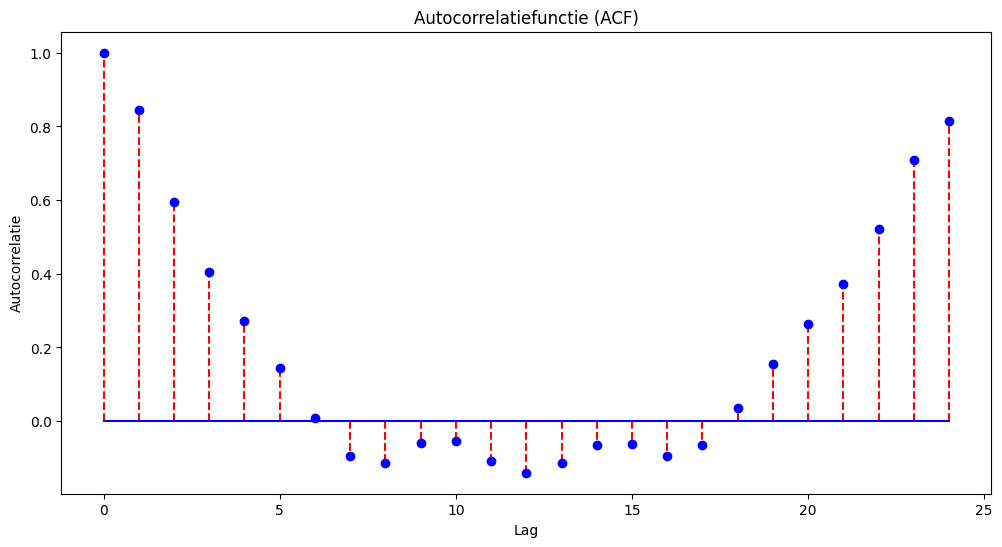

In [263]:
acf = sm.tsa.acf(data_train['cnt'], nlags=24)
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf)), acf, markerfmt='bo', basefmt='b-', linefmt='r--')
plt.title('Autocorrelatiefunctie (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelatie')
plt.show()


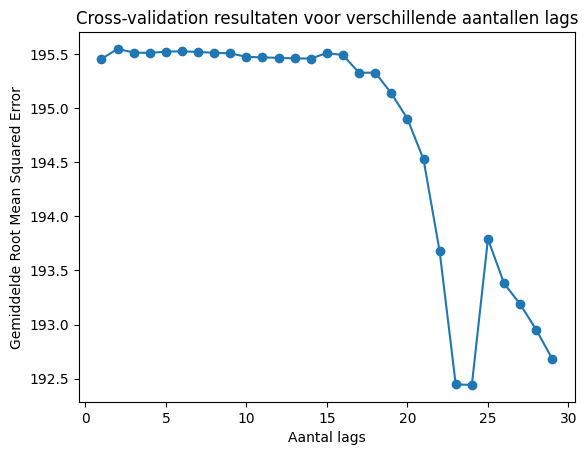

Het beste aantal lags is 24 met een gemiddelde RMSE van 192.4428.


In [264]:
# Cross-validation met TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lijst om de RMSE voor elk aantal lags op te slaan
rmse_values = []

# Loop over verschillende aantallen lags
for lag in range(1, 30):
    rmse_fold = 0
    
    # Cross-validation
    for train_index, test_index in tscv.split(data_train):
        train, test = data_train.iloc[train_index], data_train.iloc[test_index]
        
        # Pas het AutoReg-model toe op de trainingsset
        model = AutoReg(train['cnt'], lags=lag).fit()
        
        # Voorspel op de testset
        predictions = model.predict(start=test.index[0], end=test.index[-1])
        
        # Bereken de root mean squared error voor deze fold
        rmse_fold += np.sqrt(mean_squared_error(test['cnt'], predictions))
     
    
    # Bereken de gemiddelde root mean squared error voor alle folds
    rmse_values.append(rmse_fold / n_splits)

# Vind het aantal lags met de laagste gemiddelde RMSE
best_lag = np.argmin(rmse_values) + 1  # Voeg 1 toe omdat de index vanaf 0 begint

# Plot de RMSE voor verschillende aantallen lags
plt.plot(range(1, 30), rmse_values, marker='o')
plt.xlabel('Aantal lags')
plt.ylabel('Gemiddelde Root Mean Squared Error')
plt.title('Cross-validation resultaten voor verschillende aantallen lags')
plt.show()

print(f"Het beste aantal lags is {best_lag} met een gemiddelde RMSE van {rmse_values[best_lag-1]:.4f}.")


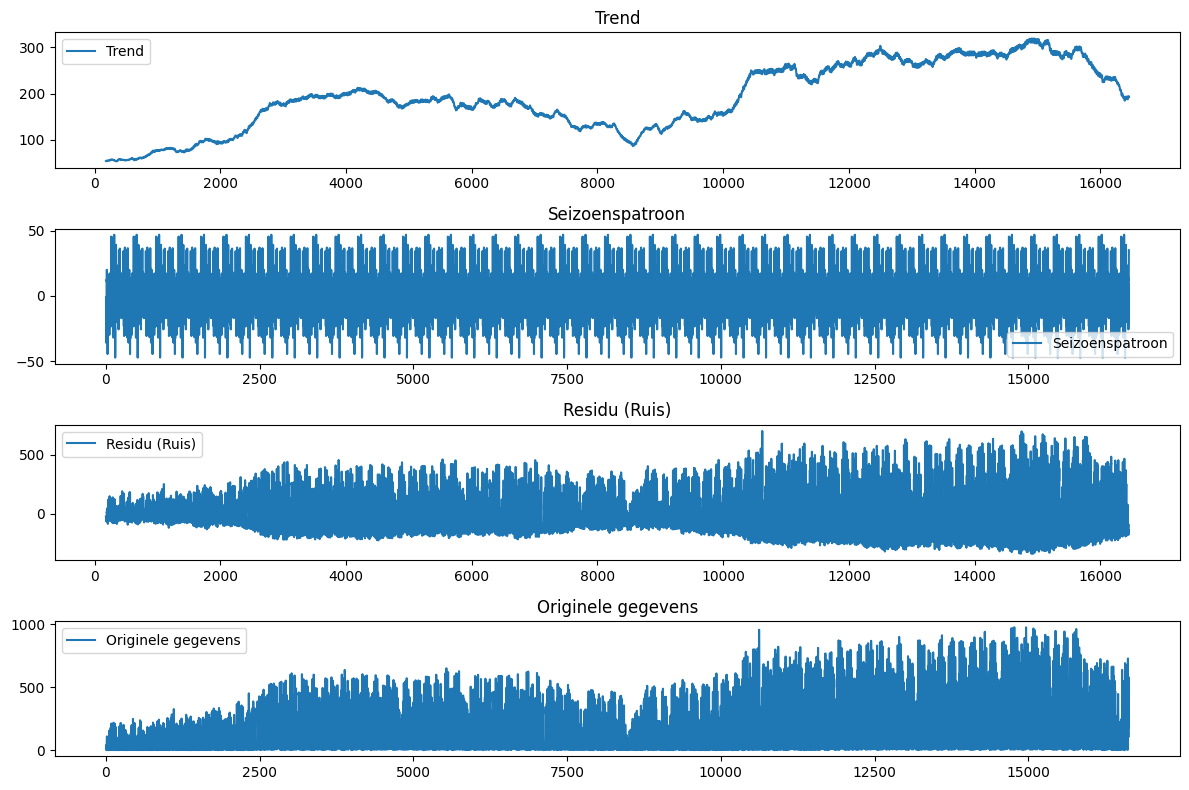

In [265]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data_train['cnt'], model='additive', period=365)

# Plot de ontleding
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seizoenspatroon')
plt.title('Seizoenspatroon')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.resid, label='Residu (Ruis)')
plt.title('Residu (Ruis)')
plt.legend()

plt.subplot(414)
plt.plot(data_train['cnt'], label='Originele gegevens')
plt.title('Originele gegevens')
plt.legend()

plt.tight_layout()
plt.show()

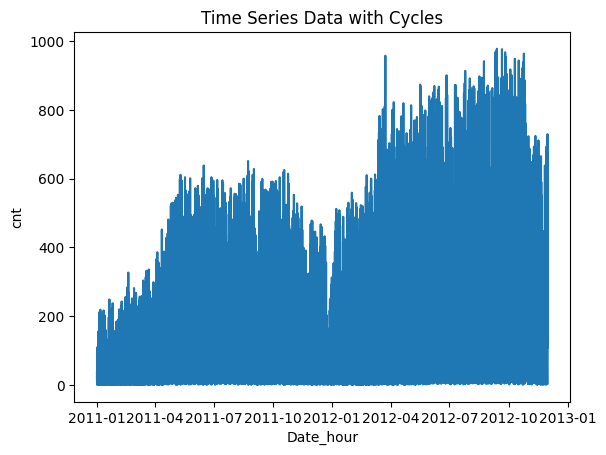

In [266]:
import matplotlib.pyplot as plt

plt.plot(data_train['date_hour'], data_train['cnt'])
plt.xlabel('Date_hour')
plt.ylabel('cnt')
plt.title('Time Series Data with Cycles')
plt.show()


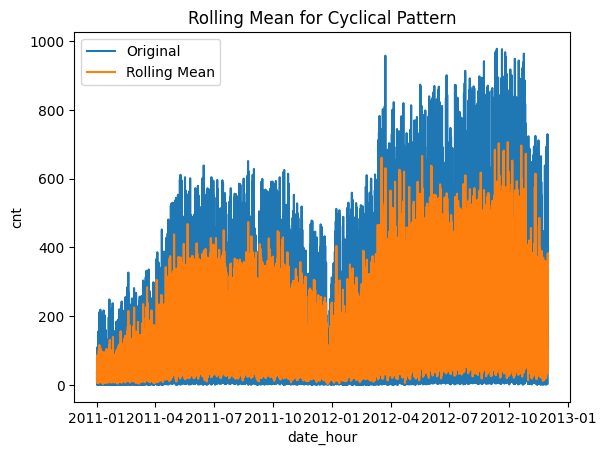

In [267]:
plt.plot(data_train['date_hour'], data_train['cnt'], label='Original')
plt.plot(data_train['date_hour'], data_train['cnt'].rolling(window=7).mean(), label='Rolling Mean')
plt.xlabel('date_hour')
plt.ylabel('cnt')
plt.title('Rolling Mean for Cyclical Pattern')
plt.legend()
plt.show()


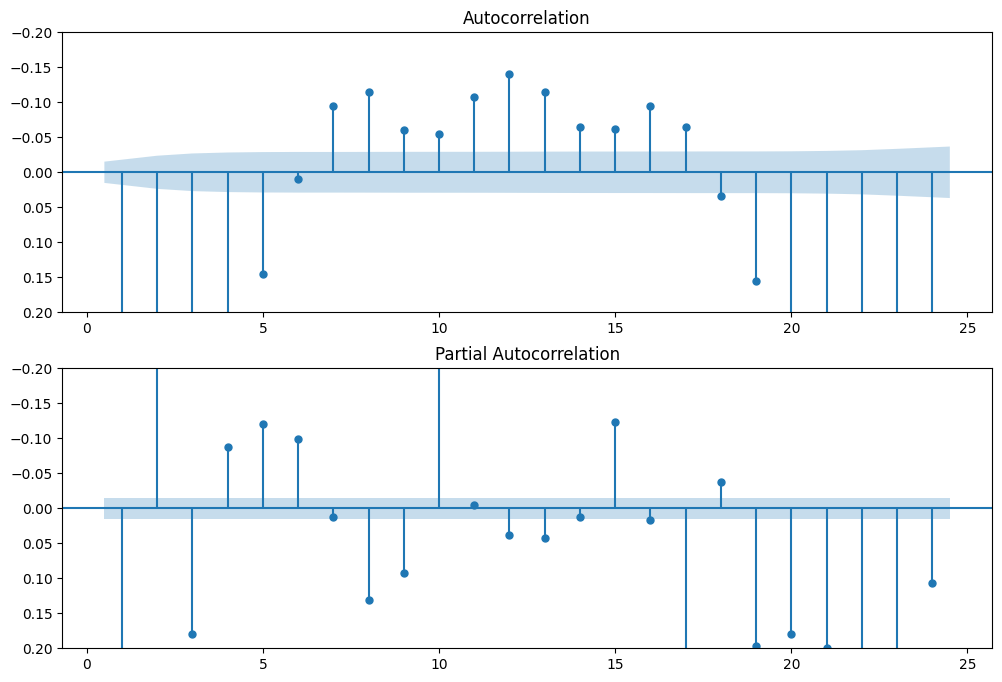

In [268]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(data_train['cnt'],lags=24, zero=False, ax=ax1)

ax1.set_ylim(0.2, -0.2)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(data_train['cnt'],lags=24, zero=False, ax=ax2)

ax2.set_ylim(0.2, -0.2)
plt.show()



### **H2.4: Grafieken met Time Series** <a name='h2.4'></a>

Eerst zullen er de benodigde functies worden aangemaakt, om op die manier gemakkelijk de verschillende nieuwe time-series kolommen aan te maken. In de loop van het project zullen er kolommen worden toegevoegd aan deze functie. Hier is een korte omschrijving over de later toegevoegde kolommen en waarom ze zijn toegevoegd:

- De 'is_weekend' kolom is toegevoegd nadat er in de seizoens analyse is opgevallen dat er een verschil was in de pieken op twee dagen. Hiermee is afgeleid dat deze dagen in het weekend zullen zitten. Later is dit bevestigd door middel van een grafiek.
- De 'day_of_week' kolom is toegevoegd nadat de fourier transform een patroon van 24 tijdseenheden aan heeft gegeven. Elke 24 tijdseenheden staat in het dataframe gelijk aan een dag, waardoor de dag van de week is toegevoegd.

In [390]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Toegevoegd op basis van eigen ingeving
    df['Jaar'] = df[f'{dt_kol}'].dt.year.astype(int)
    df['Maand'] = df[f'{dt_kol}'].dt.month.astype(int)
    #df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week.astype(int)
    df['Uur'] = df[f'{dt_kol}'].dt.hour.astype(int)

    # Toegevoegd na aanleiding FFT
    df['is_weekend'] = (df[f'{dt_kol}'].dt.dayofweek >= 5).astype(int)

    # Aanmaken fourier voor W en D
    fourier_w = CalendarFourier(freq="W", order=1)
    fourier_d = CalendarFourier(freq="D", order=1)

    # Index datetime maken
    base_df[f'{dt_kol}'] = pd.to_datetime(base_df[f'{dt_kol}'])
    base_df = base_df.set_index(f'{dt_kol}')

    dp = DeterministicProcess(
        index=base_df.index,
        constant=False,
        order=1,
        seasonal=False,
        additional_terms=[fourier_w, fourier_d],
        drop=True,
    )

    fourier_feat = dp.in_sample()

    df_fou = pd.merge(
        df, fourier_feat[['sin(1,freq=D)', 'cos(1,freq=D)',
                          'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)']],
        left_on='date_hour', right_index=True)

    return df_fou

Deze functies zullen helpen om nieuwe kolommen toe te voegen aan data_train, en later ook aan data_test.

In [391]:
# Toepassen data_voorbereiding
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Uur,is_weekend,"sin(1,freq=D)","cos(1,freq=D)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)"
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,0,1,0.000000,1.000000,-0.974928,-0.222521
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,1,0.258819,0.965926,-0.982566,-0.185912
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,2,1,0.500000,0.866025,-0.988831,-0.149042
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,3,1,0.707107,0.707107,-0.993712,-0.111964
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,4,1,0.866025,0.500000,-0.997204,-0.074730


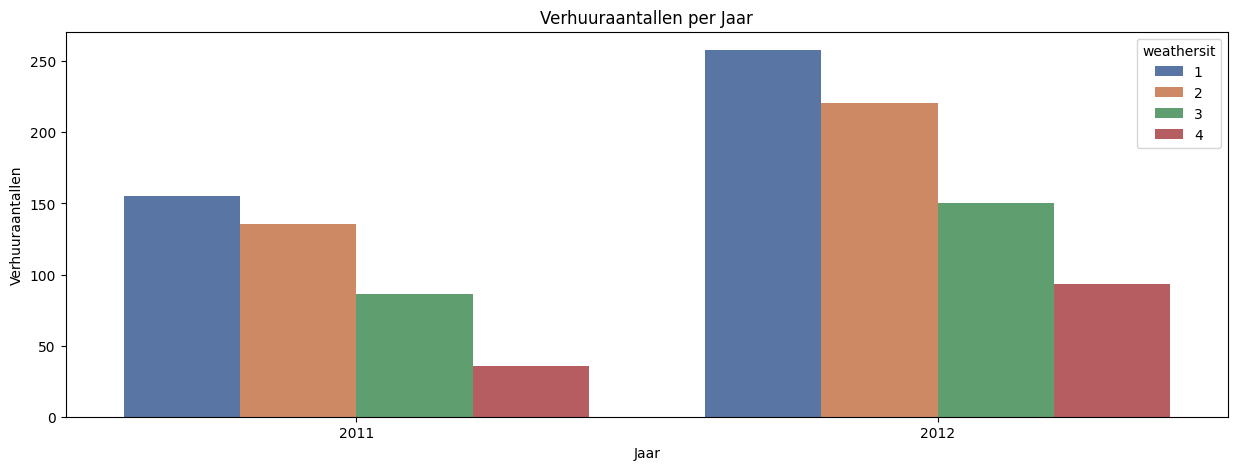

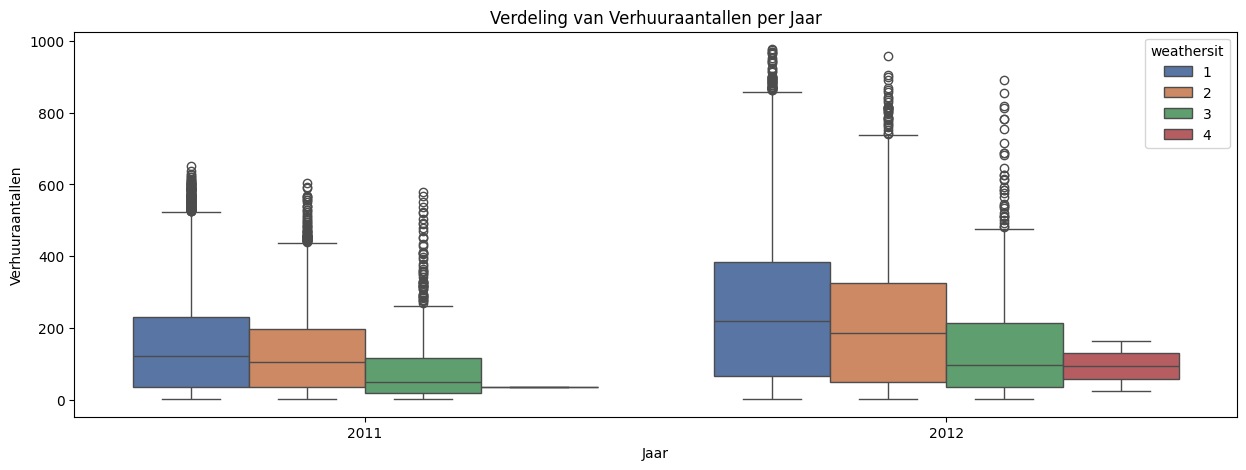

In [326]:
# Opnieuw aanmaken Grafieken class
graf = Grafieken(df, 'cnt')

# Toepassen timeplot method
graf.timeplot('Jaar', 'weathersit')

Zoals hierboven te zien is, zijn er in 2012 meer verhuursaantallen. Ook is er heel duidelijk te zien dat er een duidelijk verschil is tussen de verschillende weersituaties. Dat de weersomstandigheden een grote invloed hebben is mogelijk als het te verhuren product gebruikt wordt zonder afdekking van regen of andere neerslag. De boxplots tonen dat er geen outliers bij situatie 4 aanwezig zijn.

Bij een weerssituatie van klasse van 1 is er een algemeen hoger verhuur, dit neemt af naarmate je omhoog gaat op de schaal. Hieronder is verduidelijking over de schaal van deze kolom:

**weathersit**:
1. Helder, licht bewolkt, deels bewolkt
2. Mistig , mistig en licht bewolkt
3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte
regen en zwaar bewolkt
4. Zware regen, hagel, zware mist, sneeuw.

Voor verder onderzoek wordt er nu gekeken naar de verdeling van het verhuur per uur.

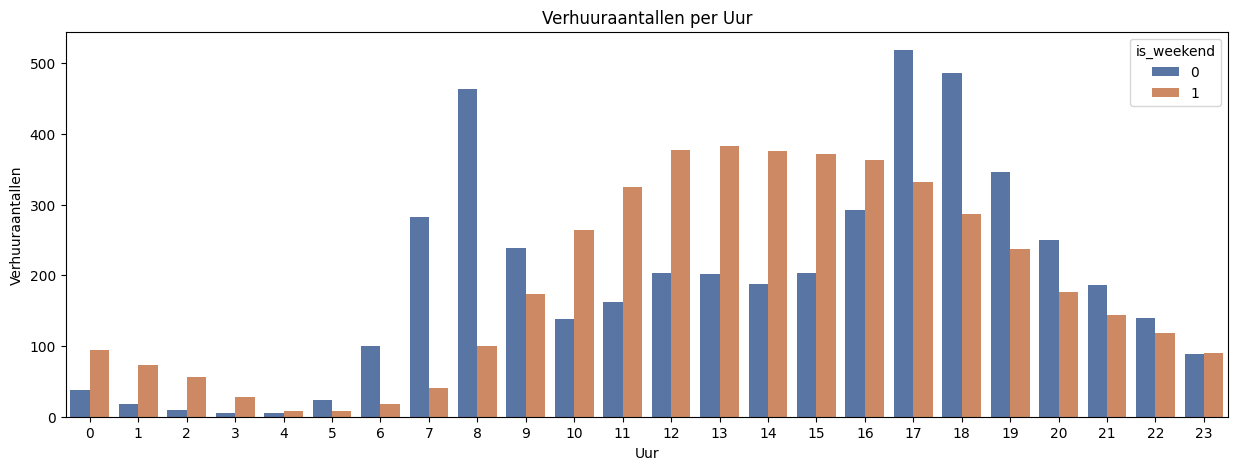

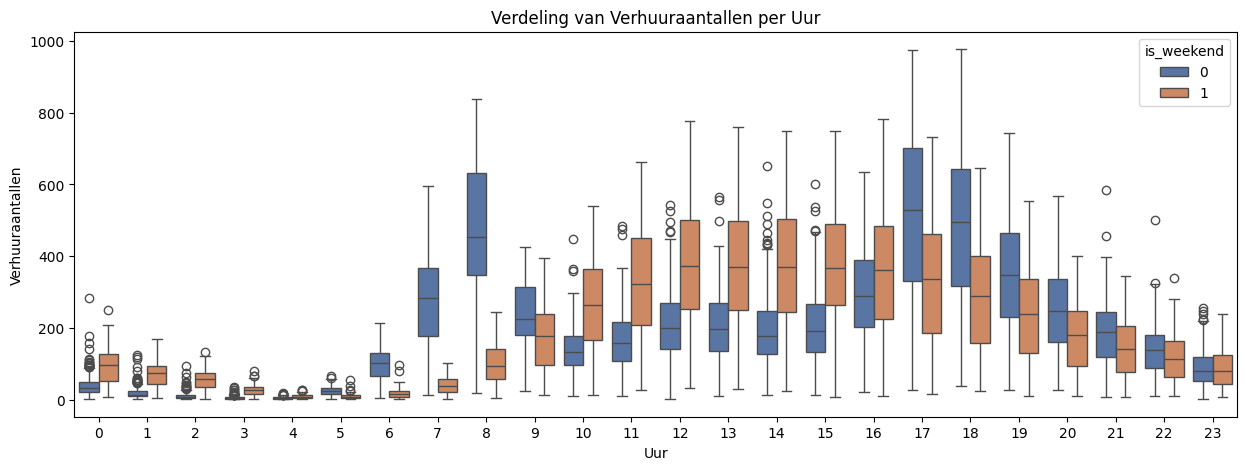

In [306]:
# Toepassen timeplot method
graf.timeplot('Uur', 'is_weekend')

De grafiek over de verhuuraantallen per uur geeft ook een duidelijke boodschap. Rond de uren van 6 t/m 8 vindt er een sterke stijging plaats, wat niet heel raar is aangezien de meeste mensen tussen 6 en 8 wakker worden. Rond de uren van 17 en 18 is er ook een gigantische piek. Echter is dit alleen van maandag t/m vrijdag, dit zijn de algemene werkdagen. 

In de weekenden zit de hoogste piek rond het begin van de middag. Wat aan dit verschil ook opvalt is dat er in de daluren (behalve van 20 t/m 22) in het weekend altijd meer verhuur is. Terwijl in de spitsuren het juist drukker is op werkdagen.

Om iets meer inzicht te krijgen over het algemene verhuur gedrag is deze grafiek ook in de vorm van boxplots gemaakt, om zo de verdeling en de outliers ook duidelijk te zien.
Het voordeel aan boxplots is dat er per waarde op de x-as een verdeling wordt getoond. Deze verdeling laten zien waar het gemiddelde ligt en of er outliers aanwezig zijn. Wat opvalt is de afwezigheid van outliers in de drukste uren van het verhuren en dat outliers ook enigzins afhankelijk zijn van tijd en de weekdag. Verder is het ook opvallend dat er geen outliers zijn aan de onderkant van de boxplots.

## **H3: Modelleren** <a name='h3'></a>

Tijdens deze stap gaat er gemodelleerd worden. Bij elk model zijn er ook tussenstappen waarbij features worden toegevoegd of verwijderd, om op deze manier de invloed van de features te kunnen beoordelen.

In [393]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)
df_test

,holiday,weathersit,temp,atemp,hum,windspeed,Jaar,Maand,Uur,is_weekend,"sin(1,freq=D)","cos(1,freq=D)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)"
0,0,1,0.26,0.3030,0.81,0.0000,2012,12,0,1,0.000000,1.000000,-0.974928,-0.222521
1,0,1,0.26,0.3030,0.81,0.0000,2012,12,1,1,0.258819,0.965926,-0.982566,-0.185912
2,0,2,0.26,0.3030,0.81,0.0000,2012,12,2,1,0.500000,0.866025,-0.988831,-0.149042
3,0,2,0.26,0.2727,0.81,0.1343,2012,12,3,1,0.707107,0.707107,-0.993712,-0.111964
4,0,1,0.26,0.2879,0.81,0.0896,2012,12,4,1,0.866025,0.500000,-0.997204,-0.074730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0,1,0.38,0.3939,0.50,0.3881,2012,12,19,0,-0.965926,0.258819,0.593820,-0.804598
452,0,1,0.36,0.3485,0.57,0.2239,2012,12,20,0,-0.866025,0.500000,0.563320,-0.826239
453,0,1,0.34,0.3182,0.61,0.2239,2012,12,21,0,-0.707107,0.707107,0.532032,-0.846724
454,0,1,0.34,0.3485,0.61,0.0896,2012,12,22,0,-0.500000,0.866025,0.500000,-0.866025


In [394]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X, y).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

def feature_scan(model):
    """
    Een functie die een grafie met de feature importances kan maken.
    Dit werkt in ieder geval voor de RF en XGB modellen.

    Parameters:
    ----------
    model : ML-model
    Het model waarvan je de feature importances wilt tonen.

    Returns:
    ----------
    None
    Laat een grafiek zien met daarin de invloed van alle features.
    """
    # Aanmaken en sorteren invloed kolommen
    invloed = pd.Series(model.feature_importances_, index=X.columns)
    invloed = invloed.sort_values(ascending=True)

    # Plotten grafiek met invloed
    invloed.plot(kind='barh', figsize=(10, 6))
    plt.ylabel('Features')
    plt.xlabel('Invloed')
    plt.show()
    

In [351]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=456, random_state=SEED)

# Aanmaken van de folds
cv = TimeSeriesSplit(n_splits=5, test_size=456)


### **H3.1: Lineaire Regressie** <a name='h3.1'></a>

#### **De werking van lineaire regressie** 
De waarde van een afhankelijke variabele voorspellen op basis van een of meer onafhankelijke variabelen. De formule van lineare regressie is y = b0 + b1x. b0 is het snijpunt met de y-as, b1 is de helling van de lijn, x is de onafhankelijke variabele en y is de afhankelijke variabele. (pp uit de lessen)


#### **Loss functie**

Een loss functie is een manier om te meten hoe goed een lineair regressiemodel de gegevens beschrijft. Het is een functie die de fout of afwijking tussen de werkelijke uitvoer en de voorspelde uitvoer kwantificeert. Een veel gebruikte loss functie voor lineaire regressie is de mean squared error (MSE) functie, die het gemiddelde van de kwadraten van de fouten berekent. Hoe kleiner de MSE, hoe beter het model de gegevens past. Voor deze opdracht gebruiken wij de root mean squared error (RMSE). 

De formule is als volgt:   $RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y_i})^2}$ 

waar N: aantal waarnemingen is, i: de index, y_i: true labels en ^y_i: predicted labels is

(notebook loss_functions)

#### **Regularisatie**

De vorm van regularisatie die van toepassing is op lineaire regression is de L1 en L2 regularisatie. Ook wel de Lasso (L1) en ridge (L2) regularisatie genoemd. Door regularisatie toe te passen, wordt een complex model tijdens het trainen vereenvoudigd. L1 voegt de “absolute waarde van de grootte” (“absolute value of magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. L2 voegt de “kwadratische omvang” (“squared magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. (Nagpal, 2022)

**Lasso (L1)**<br>
Wiskundige formule voor L1 is:
$\lambda||w||_1$

Waarbij:
- $w$ : L1-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Lasso (ook bekend als L1-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de absolute waarden van de gewichten. Het effect dat Lasso heeft is dat het sommige gewichten reduceert to nul. Hierdoor worden sommige kenmerken volledig genegeeerd, waardoor feature selectie mogelijk wordt gemaakt. Door middel van feature selectie wordt de kans op overfitting verminderd. (Jain, 2023; Team, 2020)

**Ridge (L2)**<br>
De Wiskundige formule voor L2 is:
$\lambda w^2$

Waarbij:
- $w$ : L2-norm van de gewichtsvector
- $\lambda$ : de regularisatieparameter

Ridge (ook bekend als L2-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de kwadraten van de gewichten. Het effect dat Ridge heeft is dat het de waarden van gewichten dicht naar de nul brengt, maar niet nul maakt. De ridge manier gaat de mogelijke overfitting tegen door te zorgen dat de gewichten geen te grootte waarden kunnen aannemen. (Jain, 2023; Team, 2020)


Nu het duidelijk is wat lineaire Regressie inhoud, kan er een model worden opgesteld.

In [330]:
lr = LinearRegression(n_jobs=-1)

model_score(lr)

Root Mean Squared Error: 117.2269334691733


In [277]:
param_lr = {
    'fit_intercept': [True, False],
    'copy_X' : [True, False],
    'positive' : [False, True]
}

 
# Uitvoeren van Grid Search CV
grid_score(lr, param_lr)

Beste RMSE: 126.7587963971991
Beste parameters:
{'copy_X': True, 'fit_intercept': True, 'positive': False}


In [331]:
lr_tuned = LinearRegression(n_jobs=-1)

model_score(lr_tuned)

Root Mean Squared Error: 117.2269334691733


### **H3.2: KNN Regressor**

Wij hebben gekozen om een k-nearest neighbors model te gebruiken. Een K-nearest neighbours model (KNN) kan gebruikt worden voor classificatie of regressie problemen. In een KNN model word voor het voorspellen gekeken naar datapunten die in de buurt van de waarde die we willen voorspellen zitten, ofwel de "neighbours". Het model neemt dus de X waarden van de data die voorspeld moet worden, en vergelijkt dit met de X waarden van de trainingsdata die er vergelijkbaar uit ziet. Zo kan er een voorspelling worden gemaakt over de y waarde. Hier voor is er de mogelijkheid gebruik te maken van 3 verschillende metrics.(IBM, 2023) 

Er zijn enkele voordelen verbonden aan een KNN model. Zo is het model niet zo complex als andere modellen, wat de implementatie makkelijker maakt. Verder zijn er weinig hyperparameters, dit is zowel een voordeel als een nadeel.

Omdat het model redelijk simpel is, wordt er op andere vlakken ingeleverd. Zo kan het model met grotere datasets veel eisen van de computer. Ook is er een hogere kans op overfitting. (GeeksforGeeks, 2023)

In [332]:
# opstellen K-Nearest Neighbors model
knn = KNeighborsRegressor(n_jobs=-1)

model_score(knn)

Root Mean Squared Error: 53.38359939354527


In [280]:
# Bekijken aantal neighbors
train_accuracies = {}
test_accuracies = {}
neighbors = range(1, 11)
for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)
display(train_accuracies, test_accuracies)

{1: 1.0,
 2: 0.9617933519948705,
 3: 0.952532876750606,
 4: 0.9471164568602652,
 5: 0.9431811308310649,
 6: 0.9376110687476181,
 7: 0.9314414836268978,
 8: 0.9253183425766699,
 9: 0.9202783611744393,
 10: 0.914380469047617}

{1: 0.8350752950905423,
 2: 0.907974367342016,
 3: 0.9222023643983949,
 4: 0.9105894076632437,
 5: 0.9107944214545192,
 6: 0.9074810627346148,
 7: 0.9070828890301813,
 8: 0.9009005913222629,
 9: 0.9037613048145311,
 10: 0.8974233601115442}

In [333]:
knn = KNeighborsRegressor(n_neighbors=4)

model_score(knn)

Root Mean Squared Error: 54.4182475724793


In [334]:
# parameters voor de GridSearch
params_knn = {'weights':['uniform', 'distance'],
             'metric':['minkowski','euclidean','manhattan' ],
             'algorithm':['ball_tree', 'kd_tree', 'brute']}

grid_score(knn, params_knn)

c:\Users\crazy\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste RMSE: 55.75803076569273
Beste parameters:
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'weights': 'uniform'}


In [352]:
# uitkomsten GridSearch toepassen
knn_tuned = KNeighborsRegressor(algorithm='ball_tree', n_jobs=-1, metric='minkowski', n_neighbors=4, weights='uniform')

model_score(knn_tuned)

Root Mean Squared Error: 54.4182475724793


What is the k-nearest neighbors algorithm? | IBM. (n.d.). https://www.ibm.com/topics/knn

GeeksforGeeks. (2023, November 9). K Nearest neighbor KNN algorithm. https://www.geeksforgeeks.org/k-nearest-neighbours/

### **H3.3: Decision tree regressor** <a name='h3.3'></a>

De Decision Tree Regressor wordt, in tegenstelling tot de Decision Tree Classifier, gebruikt voor regressieproblemen. Een Decision Tree is opgebouwd uit verschillende knooppunten (nodes). De wortel (root node) is het startknooppunt van de boom en bevat alle beschikbare data. De wortel wordt vervolgens gesplitst in twee interne knooppunten (internal nodes) op basis van een bepaald kenmerk en drempelwaarde. Elke interne knoop vertegenwoordigt een beslissingspunt waar de boom bepaalt welke richting te volgen op basis van de kenmerken van de gegeven datapunten. Elk intern knooppunt wordt op zijn beurt weer gesplitst in twee, hetzij in andere interne knooppunten, hetzij in bladeren (leaf nodes). Deze splitsingen worden herhaald totdat de boom de bladeren bereikt. Een blad is het uiteindelijke niveau van de boom en vertegenwoordigt de voorspelde uitkomst voor de gegeven invoer


*Moet ik het ook nog hebben over gini index en entropy?*

https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/classification-and-regression-trees?ex=1
https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda

In [336]:
dt = DecisionTreeRegressor(random_state=42)  

model_score(dt)

Root Mean Squared Error: 54.01557199126803


In [285]:
param_dtr = {
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

# Uitvoeren van Grid Search CV
grid_score(dt, param_dtr)

Beste RMSE: 56.675261679963555
Beste parameters:
{'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [395]:
dt_tuned = DecisionTreeRegressor(criterion='squared_error',
                                 max_depth=None,
                                 min_samples_leaf=4,
                                 min_samples_split=2)

model_score(dt_tuned)

Root Mean Squared Error: 49.04092626266224


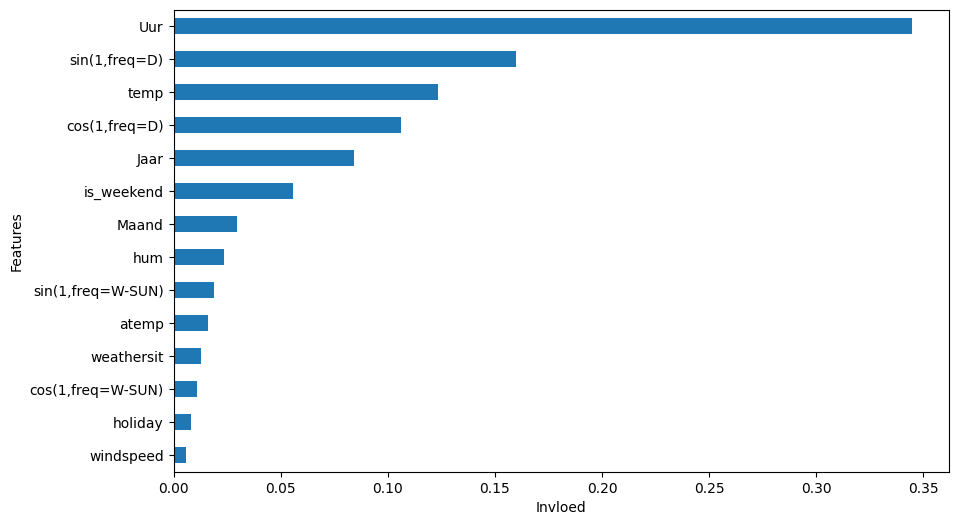

In [338]:
feature_scan(dt_tuned)

### **H3.4: Random Forest Regressor** <a name='h3.4'></a>
Als __ keuze model is er gekozen om Random Forest te gaan gebruiken. Random forest begint met het aanmaken van meerdere decision tree modellen, die elk tegelijk gaan trainen en voorspellen. Deze methode heet ensemble learning, het gebruiken van verschillende of meerdere modellen om tot een voorspelling te komen. Bij een Random Forest wordt er enkel gebruik gemaakt van Decision Trees. Nadat elk van de trees een voorspelling heeft gemaakt, wordt uit die voorspellingen het gemiddelde berekent om zo tot een antwoord te komen op het regressie probleem.

Het aantal gebruikte features is bij een Random Forest afhankelijk van een hyper-parameter: max_features. Deze parameter zorgt ervoor dat er een limiet zit op de features, zodat het ensemble model niet te afhankelijk kan worden van een paar features. Ook niet alle data wordt bij elke tree ingezet, om te zorgen dat er een extra willekeur inzit om overfitting tegen te gaan. (Chakure, 2022)

Deze eigenschappen van Random Forest zijn waarom wij het model gaan gebruiken.

In [339]:
#waarom doet deze het niet?
# Opstellen van Random Forest Regressor model
rf = RandomForestRegressor(random_state=SEED,
                              n_jobs=-1)

# Bekijken van de RMSE
model_score(rf)

Root Mean Squared Error: 37.84325840402451


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [289]:
param_rf = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [10, 20, 30],
    'min_samples_leaf' : [1, 2, 4]
}

# grid_score(rf, param_rf)

Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [396]:
# Toepassen van optimale parameters
rf_tuned = RandomForestRegressor(n_estimators=200,
                           max_depth=30,
                           min_samples_leaf=1,
                           random_state=SEED,
                           n_jobs=-1)

# Bekijken van de RMSE
model_score(rf_tuned)

Root Mean Squared Error: 37.78426103437784


Nu het getunede model van Random Forest is uitgevoerd, kan er gekeken worden naar de verschillende feature importances. Een grafiek met deze data geeft aan welke kolommen invloed hebben en hoe sterk de invloed is.

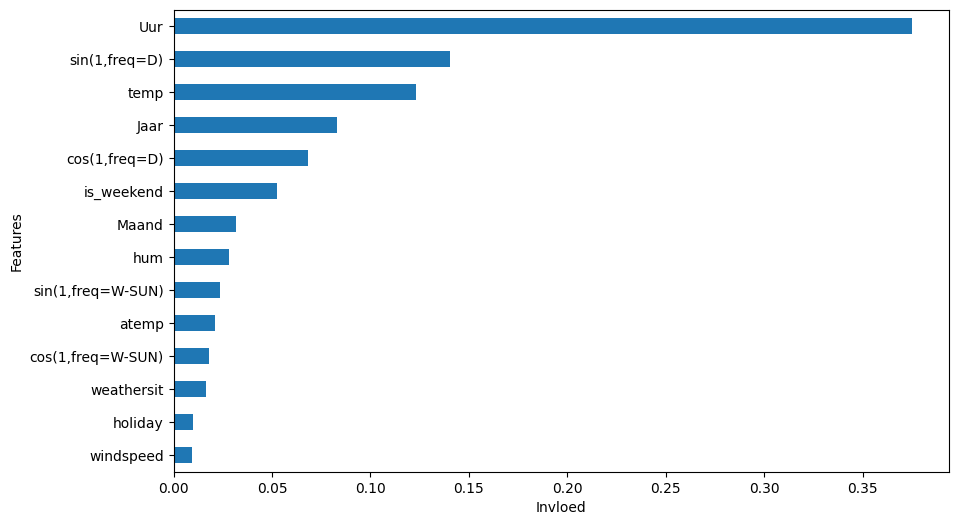

In [341]:
feature_scan(rf_tuned)

In [292]:
#submissie(rf_tuned, 'RF_2fa')

De bovenstaande grafiek toont dat, voor het maken van een random forest voorspelling, de waarden van uur en temperatuur het belangrijkste zijn. De kolom holiday heeft duidelijk het minste invloed op de voorspelling. Verder is uur duidelijk de waarde waarop het model haar voorspellingen het meest heeft gebaseerd. In de EDA was er ook duidelijk te zien dat het uur van de dag grote invloed had op de verhuuraantallen, dus dat het model hier voor heeft gekozen is logisch.

### **H3.5: XGBoost Regressor** <a name='h3.5'></a>

Als __ keuze model is er gekozen om gebruik te maken van XGBoost Regressor. Dit model heeft enkele voordelen die er toe hebben geleid om dit model te kiezen. Volgens Kumar (2019) is een van de voordelen de regularisatie van een XGBoost model. Dit model bevat zowel Lasso (L1) als Ridge (L2) regularisatie, wat ervoor zorgt dat het model moeilijker overfit. Via de Scikit Learn libary is het mogelijk om verschillende waarden, als hyperparameters, toe te voegen aan het model. De parameter alpha is voor L1 regularisatie en de parameter lambda is voor L2 regularisatie.

Een ander voordeel is de manier waarop het model pruning toepast. Bij een XGBoost model worden de bomen pas aan het einde van het model gepruned. Dit zorgt ervoor dat als er een enkele split met een negative loss voorkomt, het model niet de tak daar laat stoppen. Het model zal eerst doorgaan tot de aangegeven max_depth voordat deze gaat prunen. (Kumar, 2019)

Daarnaast is een ander groot voordeel dat XGBoost een parallel lopende ensemble is. Dit betekent dat de bomen tegelijkertijd kunnen worden opgebouwd, in tegen stelling to achtereenvolgend. Dit zorgt voornamelijk in een kortere run time bij het trainen van het model. (Hanchman, 2023)

Als eerste stap trainen we een model met enkel de standaard parameters.

In [342]:
# Opstellen van XGBoost Regressor model
xgb = XGBRegressor(n_jobs=-1,
                   random_state=SEED)

# Bekijken van de RMSE
model_score(xgb)

Root Mean Squared Error: 37.458258453583944


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [294]:
# Opstellen van de parameter dict
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [5, 10, 20],
}

# Uitvoeren van de gridsearch
grid_score(xgb, param_xgb)

Beste RMSE: 38.61951823099327
Beste parameters:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}


Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [364]:
# Toepassen van optimale parameters
xgb_tuned = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         random_state=SEED,
                         n_jobs=-1)

# Bekijken van de RMSE
model_score(xgb_tuned)

Root Mean Squared Error: 35.358898846149


Ook bij XGBoosting zal worden gekeken naar de feature importance.

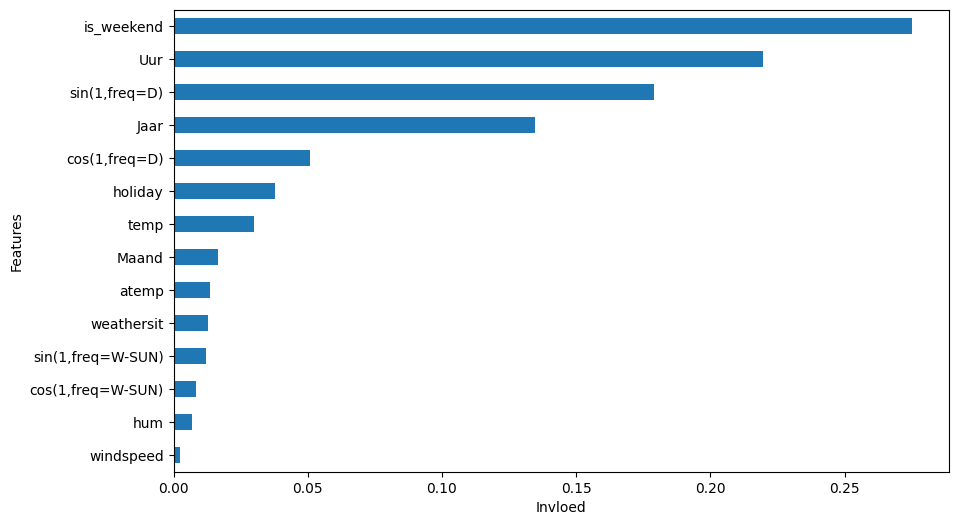

In [344]:
feature_scan(xgb_tuned)

De bovenstaande grafiek toont dat, voor het maken van een XGBoost voorspelling, de waarden van uur en jaar het belangrijkste zijn. De kolom windspeed heeft het minste invloed op de voorspelling. De waarden van uur en jaar liggen dichtbij elkaar qua invloed. Wat bij deze grafiek ook duidelijk is te zien, is dat alle waarden iets hoger liggen dan bij random forest.

In [397]:
submissie(xgb_tuned, 'XGB_new')

vs_XGB_new_1123154553.csv has been saved!


### **H3.6: Ensemble, StackingRegressor** <a name='h3.6'></a>

Binnen machine learning zijn er vele verschillende ensemble modellen, dit zijn modellen die gebruik maken van andere modellen om zo de voorspellingte kunnen vormen. Binnen het kader van Ensemble learning zijn er drie verschillende typen: bagging, boosting en stacking. 

**Bagging:**<br>
Bij bagging wordt de data gesplitst in meerdere gelijke delen, een voorbeeld hiervan komt voor bij RandomForestRegressor. Elke tree die RandomForest aanmaakt gebruikt een andere subset aan features om de voorspelling te maken. Van deze voorspelling wordt vervolgens een gemiddelde berekent, deze waarde dient als de voorspelling van het model.

**Boosting:**<br>
Bij boosting wordt er eerste een model getrained op de dataset. Vervolgens gaat het tweede model zich bezig houden met het verbeteren van de voorspelling, dit gebeurt door de gewichten op de verkeerd voorspelde datapunten te vergroten. Dit herhaalt zich totdat er geen verbetering meer plaats vind of tot het maximale aantal rondes is bereikt. Een populair voorbeeld van boosting in ML is het gebruik van ADABoost.

**Stacking:**<br>
Als keuze voor een ensemble model is er gekozen om te werken met StackingRegressor. Net als bij bagging en boosting combineerd stacking meerdere modellen om tot een voorspelling te komen voor de dataset. Anders dan bij bagging zijn er verschillende modellen die op dezelfde data worden getrained. En anders dan bij boosting word een ander model gebruikt om deze voorspellingen om te zetten naar een enkele waarde (Brownlee, 2021). Dit zorgt ervoor dat een stacking model de voor en nadelen van meerdere modellen kan combineren om een, hopelijk, sterker model te bouwen.

Wiskundig gezien kan je elke collectie van voorspelling als volgt classificeren: $\hat{y}_i,_s$. Dit staat voor de voorspelling $\hat{y}$ gebaseerd op de basis modellen $i$ op basis van sample $s$. Deze waarden worden als feature gebruikt voor het trainen van het zogenoemde meta-model, het model dat de uiteindelijke voorspellingen maakt. Bij het voorspellen van de target word er nieuwe data door de basis modellen gevoerd. Deze modellen geven een voorspelling, zodra deze voorspellingen zijn gemaakt gaat het meta-model voorspellen.

In [298]:
# Opzetten basis- en meta-modellen
basis_modellen = [
    ('knn', knn_tuned),
    ('rf', rf_tuned),
    ('lr', lr_tuned)
]

meta_model = xgb_tuned

# Toepassen van StackingRegressor
sr = StackingRegressor(estimators=basis_modellen,
                       final_estimator=meta_model,
                       n_jobs=-1)

# Bekijken van de RMSE
model_score(sr)

Root Mean Squared Error: 37.87240914103751


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [299]:
# Opstellen van parameter dict
param_sr = {
    'passthrough' : [True, False],
    'cv' : [5, 10, None]
}

# Uitvoeren van gridsearch
# grid_score(sr, param_sr)

Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [300]:
# Opzetten basis- en meta-modellen
basis_modellen = [
    ('knn', knn_tuned),
    ('rf', rf_tuned),
    ('lr', lr_tuned)
]

meta_model = xgb_tuned

# Toepassen van StackingRegressor
sr_tuned = StackingRegressor(estimators=basis_modellen,
                       final_estimator=meta_model,
                       cv=5,
                       passthrough=True,
                       n_jobs=-1)

# Bekijken van de RMSE
model_score(sr_tuned)

# submissie(sr_tuned, 'SR')

Root Mean Squared Error: 31.744961528358935


### **H3.7: Hybride model** <a name='h3.7'></a>

Hybride Machine Learning is het gebruiken van meerdere modellen om te zorgen voor een betere voorspelling. Vaak wordt er een combinatie gebruikt van een simpel (bijvoorbeeld Lineare Regressie) en een meer complex (bijvoorbeeld Random Forest) model (Holbrook, 2023). Tijdens het uitvoeren van de code worden de nodige stappen voor het model uitgelegd.

Om te beginnen met de code zal het eerste model, Linear Regression, de voorspellingen maken.

In [301]:
# Eerste model: Lineaire Regressie
lr_hm = LinearRegression(n_jobs=-1).fit(X_train, y_train)

# Voorspellen van de waarden voor train en test
y_pred_lr = lr_hm.predict(X_train)
pred_test = lr_hm.predict(X_test)

Nu de eerste voorspellingen zijn gemaakt, kan het tweede model aan de slag gaan. Bij een hybride model werkt dit anders dan bij een ensemble model. Waar er bij een ensemble gebruikt wordt gemaakt van het gemiddelde van de voorspellingen, zal een hybride model gebruik maken van de residuals van het eerste model.

In [302]:
# Berekenen van de residuals
residuals = y_train - y_pred_lr

Deze nieuwe variabele bevat het verschil tussen de werkelijke waarden en de voorspelde waarden. Het tweede model zal deze verschillen proberen te voorspellen, om deze vervolgens bij de andere voorspellingen op te kunnen tellen. Dit tweede model, XGBoost, zal dus aan de hand van de residuals gaan voorspellen wat de verschillen zullen zijn tussen de twee waarden.

In [303]:
# Tweede model: XGBoost Regressor
xgb_hm = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         reg_alpha=2,
                         reg_lambda=2,
                         random_state=SEED,
                         n_jobs=-1).fit(X_train, residuals)

# Voorspellen van de residuals
y_pred_xgb = xgb_hm.predict(X_test)

KeyboardInterrupt: 

Nu de verschillen zijn voorspeld kunnen deze bij de voorspelde waarden worden gevoegd. Op deze manier komen we bij de daadwerkelijke voorspelling komen van het hybride model.

In [ ]:
# Samenvoegen van voorspellingen
pred = np.round(pred_test + y_pred_xgb).astype(int)

# Evalueren van hybride model
mse = mean_squared_error(y_test, pred)
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 32.043863851388394


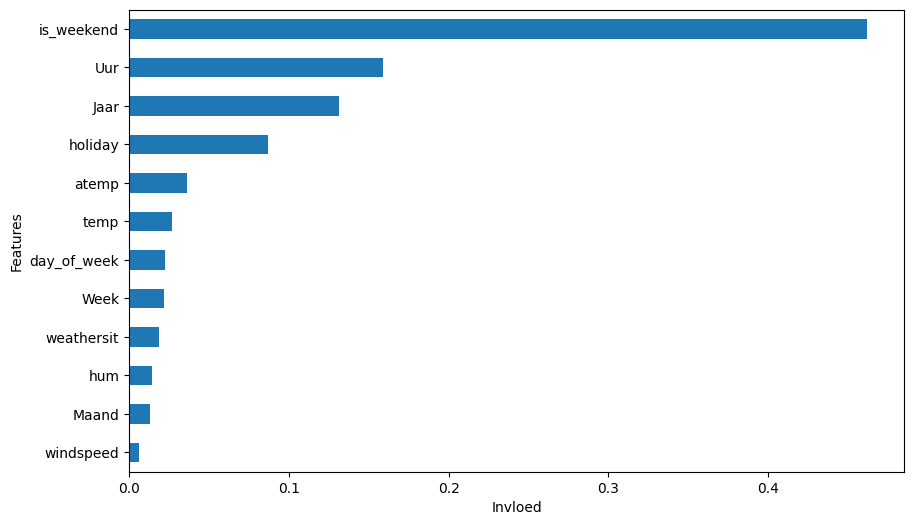

In [ ]:
feature_scan(xgb_hm)

Nu de feature importances bekeken zijn en de RMSE is berekend kunnen de waarden omgezet worden tot een dataframe die ingeleverd kan worden op kaggle. Deze code is gebaseerd op de code uit de submissie functie, echter was het niet mogelijk om de functie te gebruiken. Dit is wegens de samenvoeging van de voorspellingen.

In [ ]:
# Voorspellen op df_test
lr_test = lr_hm.predict(df_test)
xgb_test = xgb_hm.predict(df_test)

# Samenvoegen voorspelling
y_pred = np.round(lr_test + xgb_test).astype(int)

# Aanmaken df met alleen p_id en Outcome
test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': abs(y_pred)})

# Aanmaken van tijd
# tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

# Aanmaken csv bestand met timestamp
# test_predictions_df.to_csv(
#         f'Kaggle Submissions/vs_HML_try_{tijd}.csv',
#         index=False)

# print voor conformatie
# print(f'vs_HML_try_{tijd}.csv has been saved!')

vs_HML_try_1123145512.csv has been saved!


### **H3.8: SARIMAX Model** <a name='h3.8'></a>

Sarimax is een tijdserie model en de afkorting staat voor Seasonal AutoRegresive Integrated Moving Avarege eXogenous.

https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

Als eerst gaan we een Dickey-Fuller test uitvoeren. Deze bepaalt of een dataset stationair is of niet.
De data is stationair als de waarde van p kleiner of gelijk is aan het significantie level. Als de p-waarde groter is, is de data niet stationair

In [ ]:

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_train['cnt'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:


Test Statistic                -6.625165e+00
p-value                        5.901289e-09
#Lags Used                     4.300000e+01
Number of Observations Used    1.659300e+04
Critical Value (1%)           -3.430744e+00
Critical Value (5%)           -2.861714e+00
Critical Value (10%)          -2.566863e+00
dtype: float64


Onze data is stationair want p-value is 5,901289 x 10^-9 dit is veel kleiner dan een significantie level van 0.05 dus is de data stationair

In [ ]:
#Standard ARIMA Model


ARIMA_model = pm.auto_arima(df_train['cnt'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

KeyboardInterrupt: 

In [ ]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                16637
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -97944.992
Date:                Thu, 23 Nov 2023   AIC                         195903.983
Time:                        07:55:14   BIC                         195958.019
Sample:                             0   HQIC                        195921.821
                              - 16637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     67.1161      8.445      7.947      0.000      50.564      83.668
ar.L1          0.6054      0.159      3.805      0.000       0.294       0.917
ar.L2         -0.0337      0.145     -0.233      0.816      -0.317       0.250
ar.L3          0.0767      0.033      2.329      0.020       0.012       0.141
ma.L1          0.6704      0.159      4.217      0.000       0.359       0.982
ma.L2          0.2317      0.062      3.747      0.000       0.110       0.353
sigma2      7594.1784     54.850    138.454      0.000    7486.675    7701.682
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             19191.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

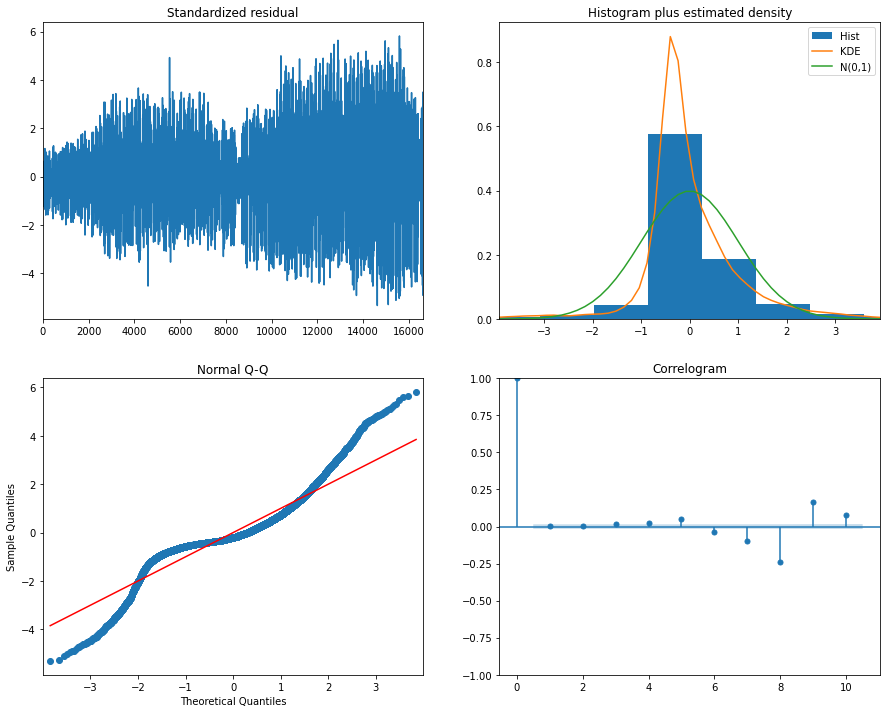

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_train.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_train["cnt"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [ ]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)

    # Convert n_periods to DateOffset
    offset = pd.DateOffset(months=n_periods)

    index_of_fc = pd.date_range(df_train.index[-1] + offset, periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_train["cnt"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_train["cnt"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

MemoryError: Unable to allocate 174. MiB for an array with shape (37, 37, 16637) and data type float64

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
split_point = int(len(df2) * 0.8)
train, test = df2[0:split_point], df2[split_point:]

In [ ]:
model = SARIMAX(train['cnt'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model = model.fit(disp=False)

Root Mean Squared Error: 33.29031536901417


C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


InvalidIndexError: (slice(None, None, None), None)

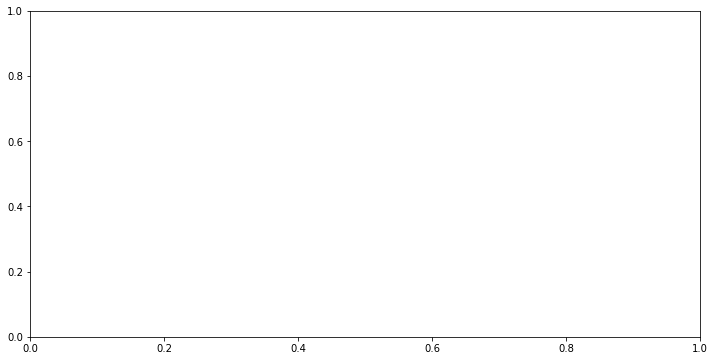

In [ ]:
forecast = model.get_forecast(steps=len(test))
predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index, predictions, label='Predictions', color='r')

# Fill area between confidence intervals
plt.fill_between(predictions.index, lower_limits, upper_limits, color='pink', alpha=0.5)

plt.legend()
plt.title('SARIMA Predictions with 95% Confidence Intervals')
plt.show()

In [ ]:
# Definieer de SARIMA parameters
order = (p, d, q)
seasonal_order = (P, D, Q, s)

# Maak en pas het SARIMA-model toe
sarima_model = sm.tsa.SARIMAX(x, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Bekijk de samenvatting van het model
print(sarima_result.summary())


In [ ]:
results = pm.auto_arima( df_train,# data  
                         # non-seasonal arguments 
                        seasonal=True,  # is the time series seasonal  
                        m=7,            # the seasonal period   
                        D=1,            # seasonal difference order   
                        start_P=1,      # initial guess for P           
                        start_Q=1,      # initial guess for Q            
                        max_P=2,        # max value of P to test       
                        max_Q=2,        # max value of Q to test                        
                       )


In [ ]:
# Load your dataset
endog = df_train

# We could fit an AR(2) model, described above
mod_ar2 = sm.tsa.SARIMAX(endog, order=(2,0,0))
# Note that mod_ar2 is an instance of the SARIMAX class

# Fit the model via maximum likelihood
res_ar2 = mod_ar2.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_ar2.summary())

# We could also fit a more complicated model with seasonal components.
# As an example, here is an SARIMA(1,1,1) x (0,1,1,4):
mod_sarimax = sm.tsa.SARIMAX(endog, order=(1,1,1),
                             seasonal_order=(0,1,1,4))
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())


In [ ]:
# x is je tijdsreeksgegevens
sarima_model = auto_arima(X, seasonal=True, m=12)  # m is de lengte van het seizoen
print(sarima_model.summary())

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda
    https://scikit-learn.org/stable/modules/linear_model.html
    https://www.coursera.org/learn/machine-learning#outcomes
    https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/
    https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/
    https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
    https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/notebook
    https://www.statsmodels.org/dev/statespace.html#seasonal-autoregressive-integrated-moving-average-with-exogenous-regressors-sarimax
    https://people.duke.edu/~rnau/Mathematical_structure_of_ARIMA_models--Robert_Nau.pdf
    https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
    https://builtin.com/data-science/l2-regularization
    https://campus.datacamp.com/courses/arima-models-in-python/seasonal-arima-models?ex=8

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


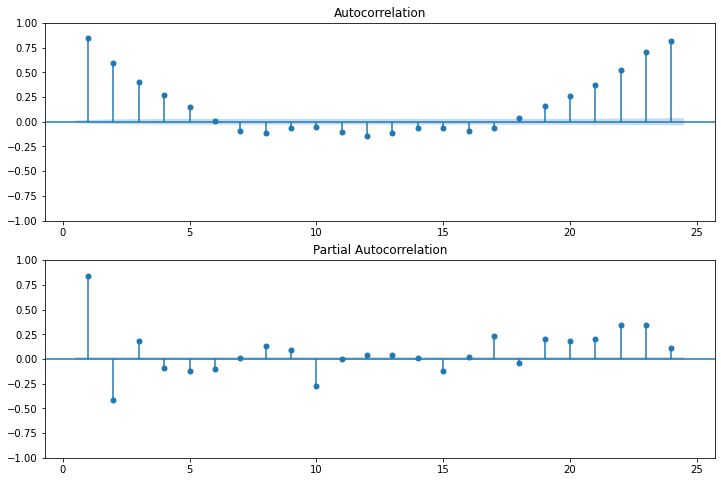

In [ ]:
# Assuming df_train is your time series data
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plot ACF
sm.graphics.tsa.plot_acf(df_train, ax=ax, lags=25, zero=False)

plt.show()

### **H3.9 Exponential Smoothing** <a name='h3.9'></a>

In [ ]:
#ets

# Voorbeeld ETS-model
model = ExponentialSmoothing(df_train['cnt'], seasonal='add', trend='add', seasonal_periods=12)
results = model.fit()

In [ ]:
plt.style.use('Solarize_Light2')

train = df2.iloc[100:-10, :]
test = df2.iloc[-10:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['cnt']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
model = Holt(np.asarray(train['data']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(9)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()

## **H4: Bevindingen** <a name='h4'></a>

## **H5: Conclusie** <a name='h5'></a>

## **Literatuurlijst** <a name='bronnen'></a>

Voor alle onderwerpen is gebruik gemaakt van de Datacamps en de lesopgaven.

**Random Forest**:
- Chakure, A. (2022, March 7). Random forest regression in Python explained. Built In. https://builtin.com/data-science/random-forest-python

**XGBoost**:
- Kumar, N. (9 maart 2019). Advantages of XGBOOST Algorithm in Machine Learning. http://theprofessionalspoint.blogspot.com/2019/03/advantages-of-xgboost-algorithm-in.html
- Hachcham, A. (2023, August 11). XGBoost: Everything you need to know. neptune.ai. https://neptune.ai/blog/xgboost-everything-you-need-to-know

**Ensemble Model**:
- Brownlee, J. (2021, April 26). Stacking ensemble machine learning with Python. MachineLearningMastery.com. https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
- sklearn.ensemble.StackingRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

**Hybride Model**:
- Holbrook, R. (2023, April 20). Hybrid models. Kaggle. https://www.kaggle.com/code/ryanholbrook/hybrid-models